# Technical Validation of the TherLid Dataset

Based on https://github.com/joamats/pulse-ox-dataset/blob/master/notebooks/4_technical_validation.ipynb


## Defines and Imports

In [55]:
!python --version

Python 3.10.12


In [56]:
# replace with own projectid to pull from bigquery
%env GOOGLE_CLOUD_PROJECT = aiwonglab

env: GOOGLE_CLOUD_PROJECT=aiwonglab


In [57]:
# install necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery
import matplotlib.pyplot as plt
import missingno as msno
import pandas_gbq
import re

import numpy as np
from numpy.polynomial import Polynomial
import warnings
warnings.filterwarnings("ignore")

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [58]:
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [59]:
# load data temperature data stored in google colab or your created version using pd.read_csv()
%%bigquery final_df --project spring-carving-271217

SELECT *
FROM `spring-carving-271217.test.merged_temp_pairs`

Query is running:   0%|          |

Downloading:   0%|          |

## Data Checks


In [60]:
final_df

unique_subject_id  unique_hospital_admission_id  unique_icustay_id  \
0                    140                           147                147   
1                   4208                          4294               4339   
2                   4208                          4294               4339   
3                   3428                          3497               3537   
4                   2571                          2623               2653   
...                  ...                           ...                ...   
13246               6898                          7025               7090   
13247               6898                          7025               7090   
13248               6579                          6705               6766   
13249               6713                          6840               6904   
13250               3151                          3214               3252   

       icustay_id  hospital_admission_id       subject_id  pair_id   pair_seq  \
0          233528                 200620        002-28721     2952   233528-1   
1         3216616                2618484        033-14395     6468  3216616-1   
2         3216616                2618484        033-14395     6467  3216616-2   
3         2901072                2354024       027-150200     6070  2901072-1   
4         2456913                1951525       022-116883     6230  2456913-2   
...           ...                    ...              ...      ...        ...   
13246     6304802                5120580  030-4134-1901.0    10370  6304802-1   
13247     6304802                5120580  030-4134-1901.0    10369  6304802-2   
13248     7154621                5827094   028-8602-923.0    10097  7154621-2   
13249     7168148                5839494   030-1413-326.0    11312  7168148-1   
13250     2486841                1976447        022-86306     1911  2486841-2   

       total_no_pairs source_db  ... los_hospital  los_ICU  \
0                   1      eicu  ...   814.850000    130.0   
1                  17      eicu  ...   558.833333    114.0   
2                  17      eicu  ...   558.833333    114.0   
3                   1      eicu  ...   661.400000     22.0   
4                   4      eicu  ...   521.816667    128.0   
...               ...       ...  ...          ...      ...   
13246               2     eicu2  ...   217.483333     66.0   
13247               2     eicu2  ...   217.483333     66.0   
13248               3     eicu2  ...   115.883333     86.0   
13249               2     eicu2  ...   797.016667    256.0   
13250               2      eicu  ...   257.333333     40.0   

      in_hospital_mortality  race_ethnicity comorbidity_score_name  \
0                       0.0           White               Charlson   
1                       0.0           White               Charlson   
2                       0.0           White               Charlson   
3                       1.0           White               Charlson   
4                       0.0           White               Charlson   
...                     ...             ...                    ...   
13246                   0.0           White               Charlson   
13247                   0.0           White               Charlson   
13248                   0.0           White               Charlson   
13249                   0.0           Black               Charlson   
13250                   1.0           White               Charlson   

      comorbidity_score_value  sofa_day1  hidden_fever  hidden_hypothermia  \
0                           3        8.0         False               False   
1                           8        7.0         False               False   
2                           8        7.0         False               False   
3                           3        NaN         False               False   
4                           4        3.0         False               False   
...                       ...        ...           ... 

### Confirm Age Distribution

In [61]:
# minimum age must be 18
final_df["admission_age"].describe()

count      13251.0
mean     61.236586
std      16.713261
min           18.0
25%           51.0
50%           63.0
75%           74.0
max           90.0
Name: admission_age, dtype: Float64

### Confirm Temperature Distrbution

In [62]:
# temperatures should be between 30 degrees C to 45 degrees C inclusive
final_df["temp_c_reference"].describe()

count    13251.000000
mean        36.806996
std          0.792647
min         30.900000
25%         36.500000
50%         36.700000
75%         37.100000
max         41.300000
Name: temp_c_reference, dtype: float64

In [63]:
final_df["temp_c_temporal"].describe()

count    13251.000000
mean        36.757037
std          0.735279
min         30.000000
25%         36.300000
50%         36.700000
75%         37.100000
max         41.800000
Name: temp_c_temporal, dtype: float64

### Confirm Time Difference Distribution

In [64]:
# the time difference between the temperature measured by the temporal thermometer and the reference thermometer must not exceed 60 minutes
final_df['datetime_charted_temporal'] = pd.to_datetime(final_df['datetime_charted_temporal'])
final_df['datetime_charted_reference'] = pd.to_datetime(final_df['datetime_charted_reference'])

final_df['difference_in_minutes'] = (final_df['datetime_charted_temporal'] - final_df['datetime_charted_reference']).abs() / pd.Timedelta(minutes=1)

final_df['difference_in_minutes'].describe()

count    13251.000000
mean        36.684552
std         18.293707
min          1.000000
25%         21.000000
50%         38.000000
75%         55.000000
max         60.000000
Name: difference_in_minutes, dtype: float64

### Confirm patients < hosptilizations < pairs order

In [65]:
# There should be more pairs than hosptilizations and there should be more hosptilizations than patients

unique_subjects = final_df["unique_subject_id"].nunique()
unique_hosptilizations = final_df["unique_hospital_admission_id"].nunique()
pairs = len(final_df)

assert unique_subjects < unique_hosptilizations
assert unique_hosptilizations < pairs

## Empirical Correction Curve

- show bias of Temporal thermomethers
- not sure if this is useful as the bland-altman plots are essentially the same viz

### By Pair Type


In [67]:
# split the dataset by pair
final_df_temporal_core = final_df[final_df["pair_type"] == 'temporal-core']
final_df_temporal_rectal = final_df[final_df["pair_type"] == 'temporal-rectal']
final_df_temporal_oral = final_df[final_df["pair_type"] == 'temporal-oral']

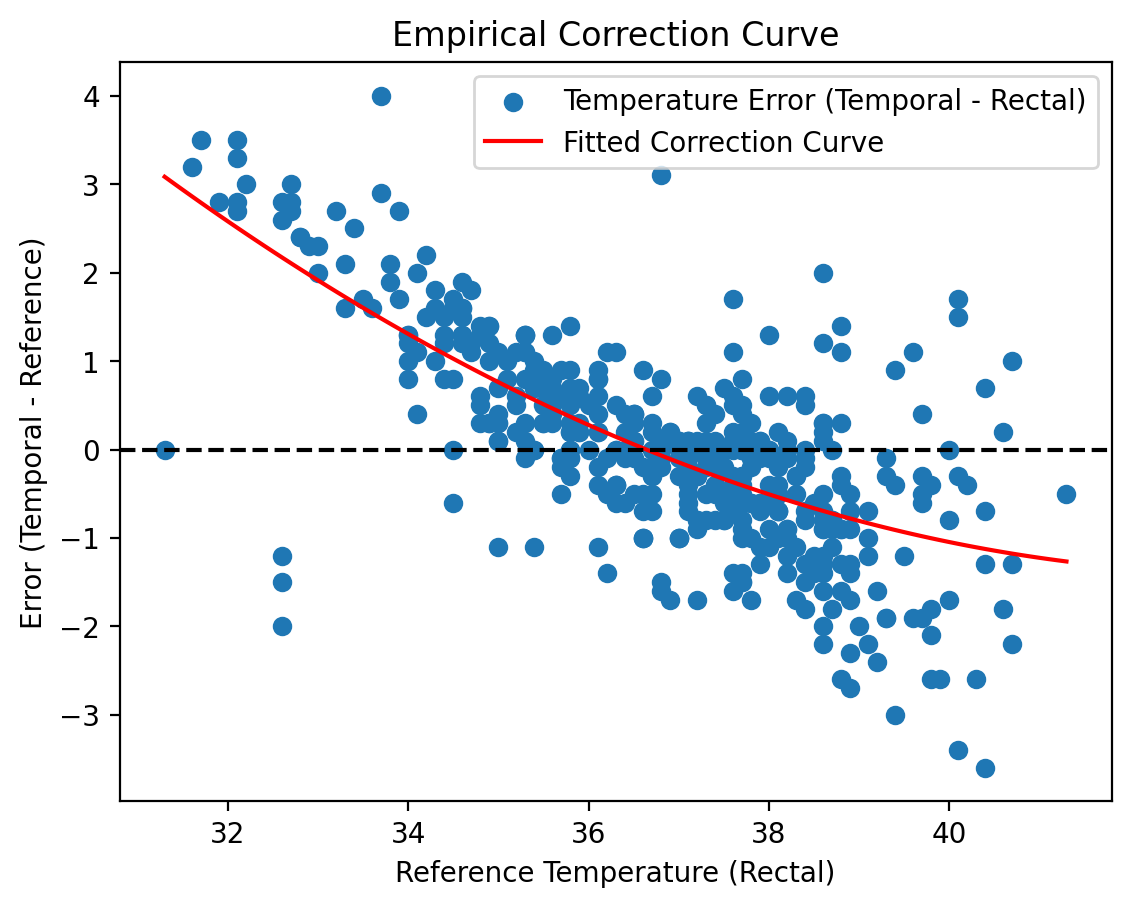

In [68]:
errors = final_df_temporal_rectal['temp_c_temporal'] - final_df_temporal_rectal['temp_c_reference']

plt.scatter(final_df_temporal_rectal['temp_c_reference'], errors, label='Temperature Error (Temporal - Rectal)')

p = Polynomial.fit(final_df_temporal_rectal['temp_c_reference'], errors, 2)
x_vals = np.linspace(min(final_df_temporal_rectal['temp_c_reference']), max(final_df_temporal_rectal['temp_c_reference']), 100)
y_vals = p(x_vals)

plt.plot(x_vals, y_vals, color='red', label='Fitted Correction Curve')

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Reference Temperature (Rectal)')
plt.ylabel('Error (Temporal - Reference)')
plt.title('Empirical Correction Curve')
plt.legend()

plt.show()

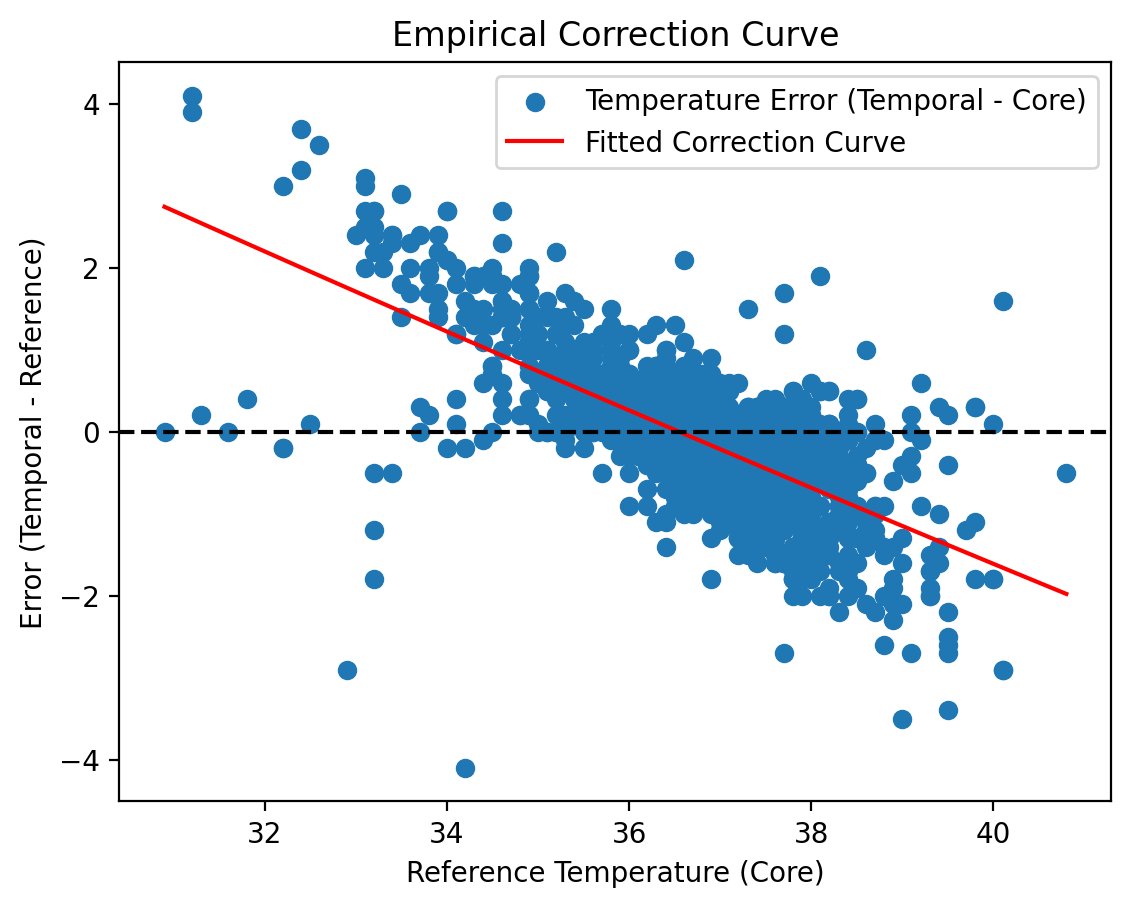

In [69]:
errors = final_df_temporal_core['temp_c_temporal'] - final_df_temporal_core['temp_c_reference']

plt.scatter(final_df_temporal_core['temp_c_reference'], errors, label='Temperature Error (Temporal - Core)')

p = Polynomial.fit(final_df_temporal_core['temp_c_reference'], errors, 2)
x_vals = np.linspace(min(final_df_temporal_core['temp_c_reference']), max(final_df_temporal_core['temp_c_reference']), 100)
y_vals = p(x_vals)

plt.plot(x_vals, y_vals, color='red', label='Fitted Correction Curve')

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Reference Temperature (Core)')
plt.ylabel('Error (Temporal - Reference)')
plt.title('Empirical Correction Curve')
plt.legend()

plt.show()

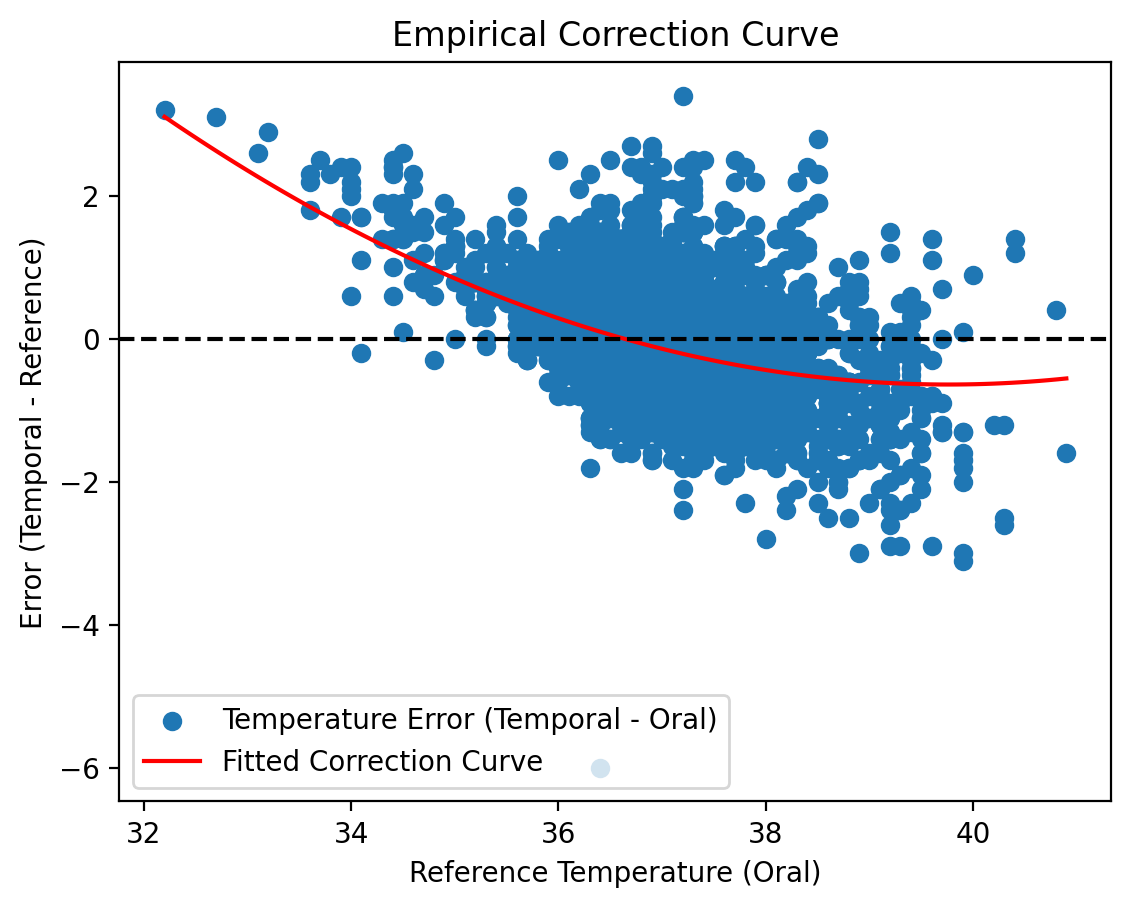

In [70]:
errors = final_df_temporal_oral['temp_c_temporal'] - final_df_temporal_oral['temp_c_reference']

plt.scatter(final_df_temporal_oral['temp_c_reference'], errors, label='Temperature Error (Temporal - Oral)')

p = Polynomial.fit(final_df_temporal_oral['temp_c_reference'], errors, 2)
x_vals = np.linspace(min(final_df_temporal_oral['temp_c_reference']), max(final_df_temporal_oral['temp_c_reference']), 100)
y_vals = p(x_vals)

plt.plot(x_vals, y_vals, color='red', label='Fitted Correction Curve')

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Reference Temperature (Oral)')
plt.ylabel('Error (Temporal - Reference)')
plt.title('Empirical Correction Curve')
plt.legend()

plt.show()

In [71]:
# probably startify by race and etc.

## Band-Altman Plots
- Shows bias mean increases with time period
- Shows White group has lower bias than Refrence Group
- May conflict with Sample size by Time Difference

In [72]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)

    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2

    md = np.mean(diff)
    sd = np.std(diff)
    up_ci = md + 1.96 * sd
    lo_ci = md - 1.96 * sd

    plt.scatter(mean, diff, alpha=0.3, s=10, color='tab:blue', label='Data')

    plt.axhline(md, color='black', linestyle='--', label='Mean Difference')
    plt.axhline(up_ci, color='tab:red', linestyle='--', label='+1.96 SD')
    plt.axhline(lo_ci, color='tab:red', linestyle='--', label='-1.96 SD')

    x_text = np.min(mean) + 0.05 * (np.max(mean) - np.min(mean))

    plt.text(x_text, md + .5, f'MEAN = {md:.2f}', color='black', fontsize=8)
    plt.text(x_text, up_ci + .5, f'+ 1.96 SD = {up_ci:.2f}', color='tab:red', fontsize=8)
    plt.text(x_text, lo_ci - .5, f'- 1.96 SD = {lo_ci:.2f}', color='tab:red', fontsize=8)

    plt.xlabel('Mean Temporal, Reference (°C)')
    plt.ylabel('Temporal-Reference (°C)')


### By Pair Type

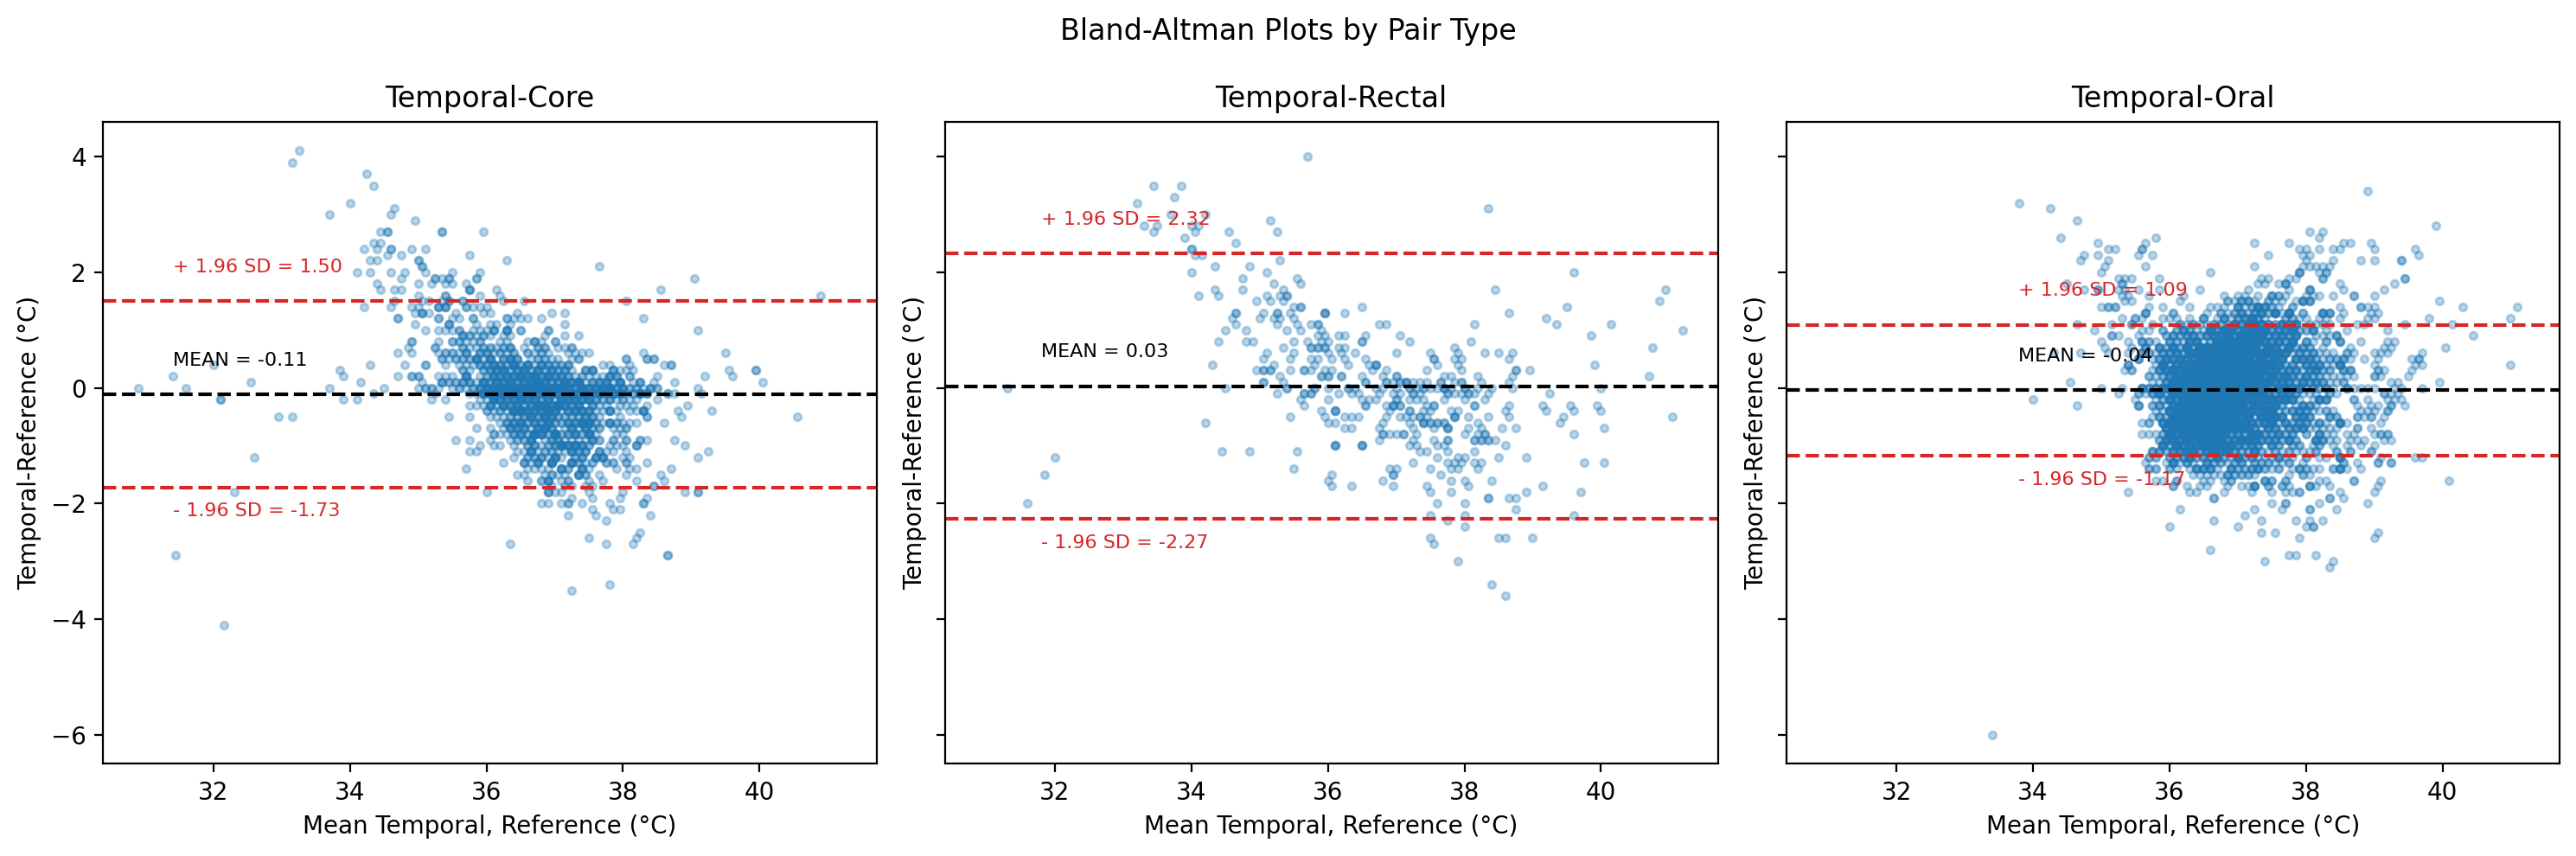

In [73]:
pairs = [final_df_temporal_core, final_df_temporal_rectal, final_df_temporal_oral]
titles = ['Temporal-Core', 'Temporal-Rectal', 'Temporal-Oral']
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for pair, ax, title in zip(pairs, axs, titles):
    plt.sca(ax)
    bland_altman_plot(pair['temp_c_temporal'], pair['temp_c_reference'])
    plt.title(f'{title}')

plt.suptitle('Bland-Altman Plots by Pair Type')
plt.tight_layout()
plt.show()

### By Time Window

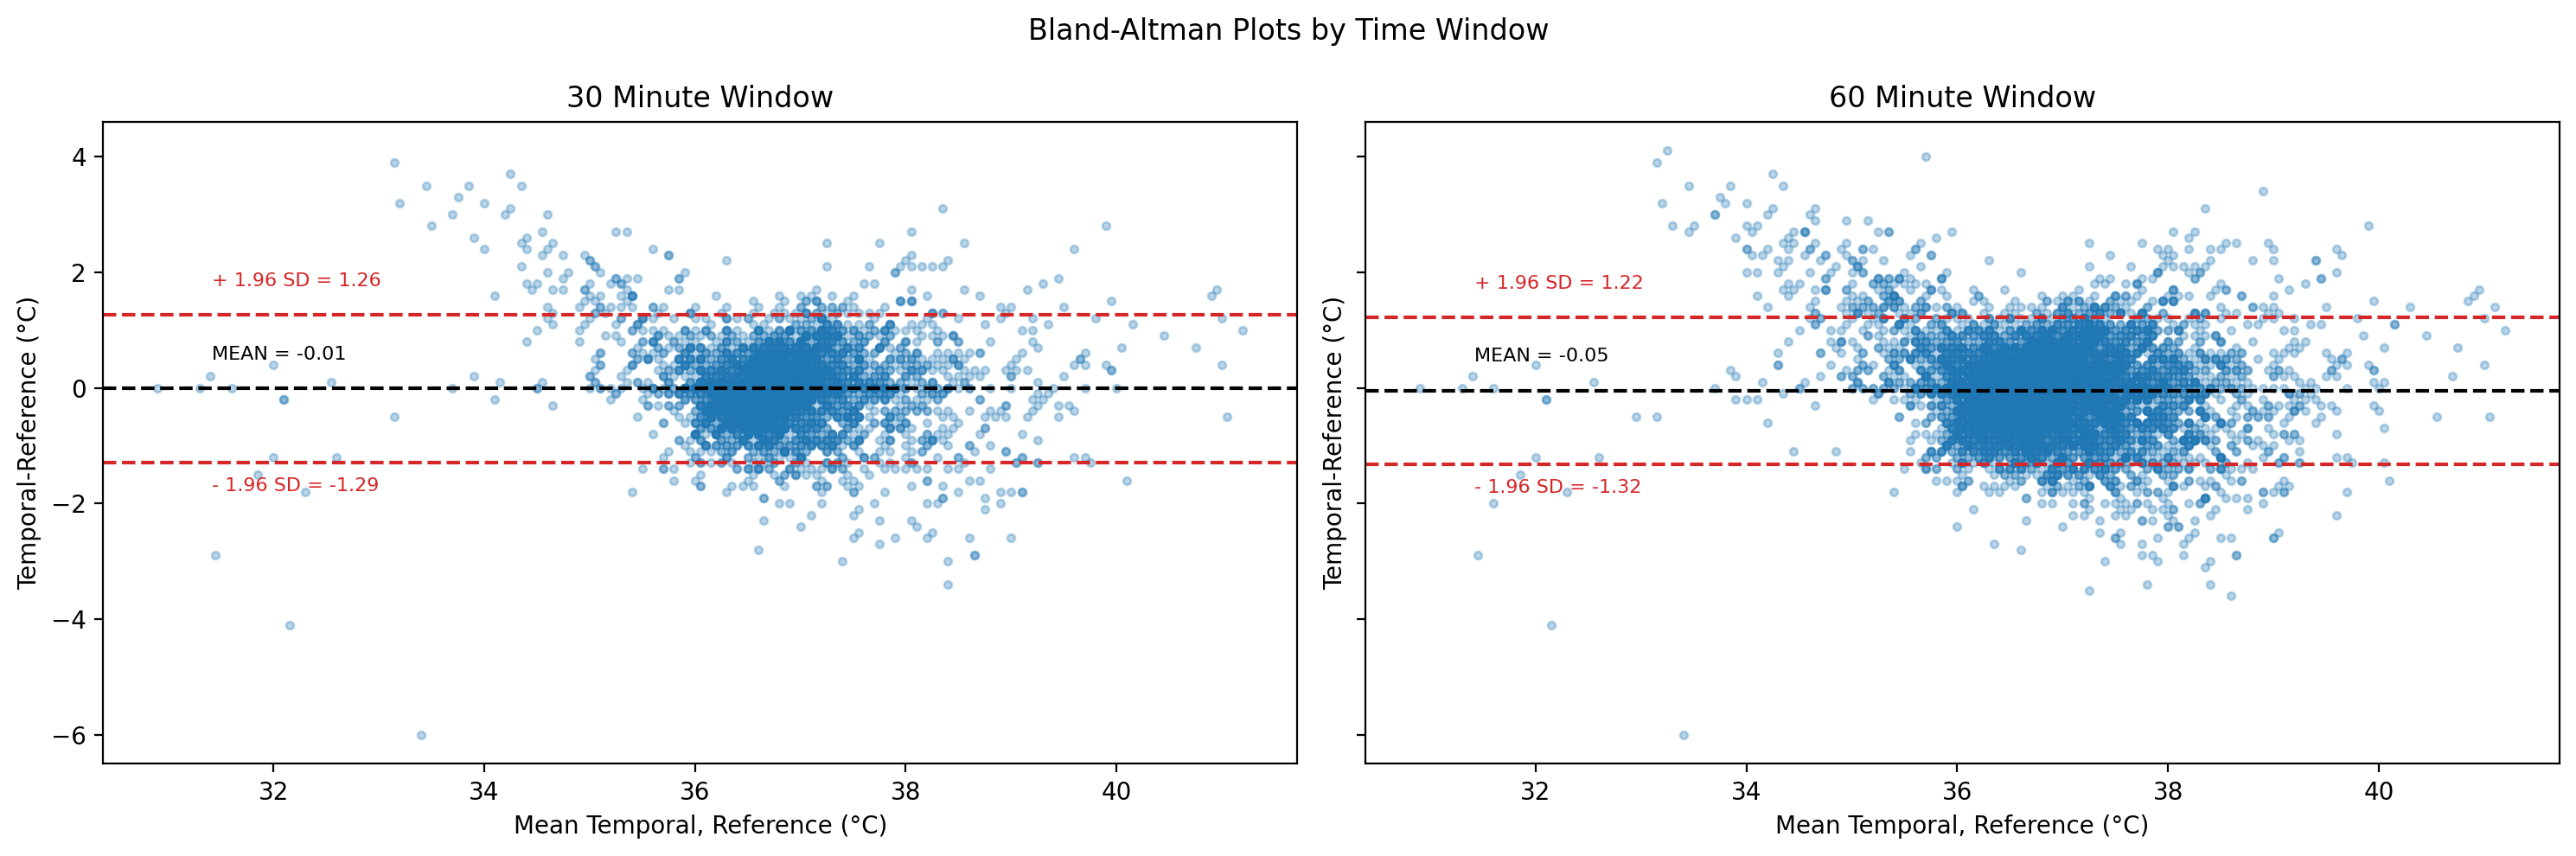

In [74]:
# not alot of observations to add more windows
final_df_30 = final_df[final_df['difference_in_minutes'] <= 30]
final_df_60 = final_df

windows = [final_df_30, final_df_60]
titles = ['30 Minute Window', '60 Minute Window']


fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for window, ax, title in zip(windows, axs, titles):
    plt.sca(ax)
    bland_altman_plot(window['temp_c_temporal'], window['temp_c_reference'])
    plt.title(f'{title}')

plt.suptitle('Bland-Altman Plots by Time Window')
plt.tight_layout()
plt.show()


#### By Pair-Type + Window

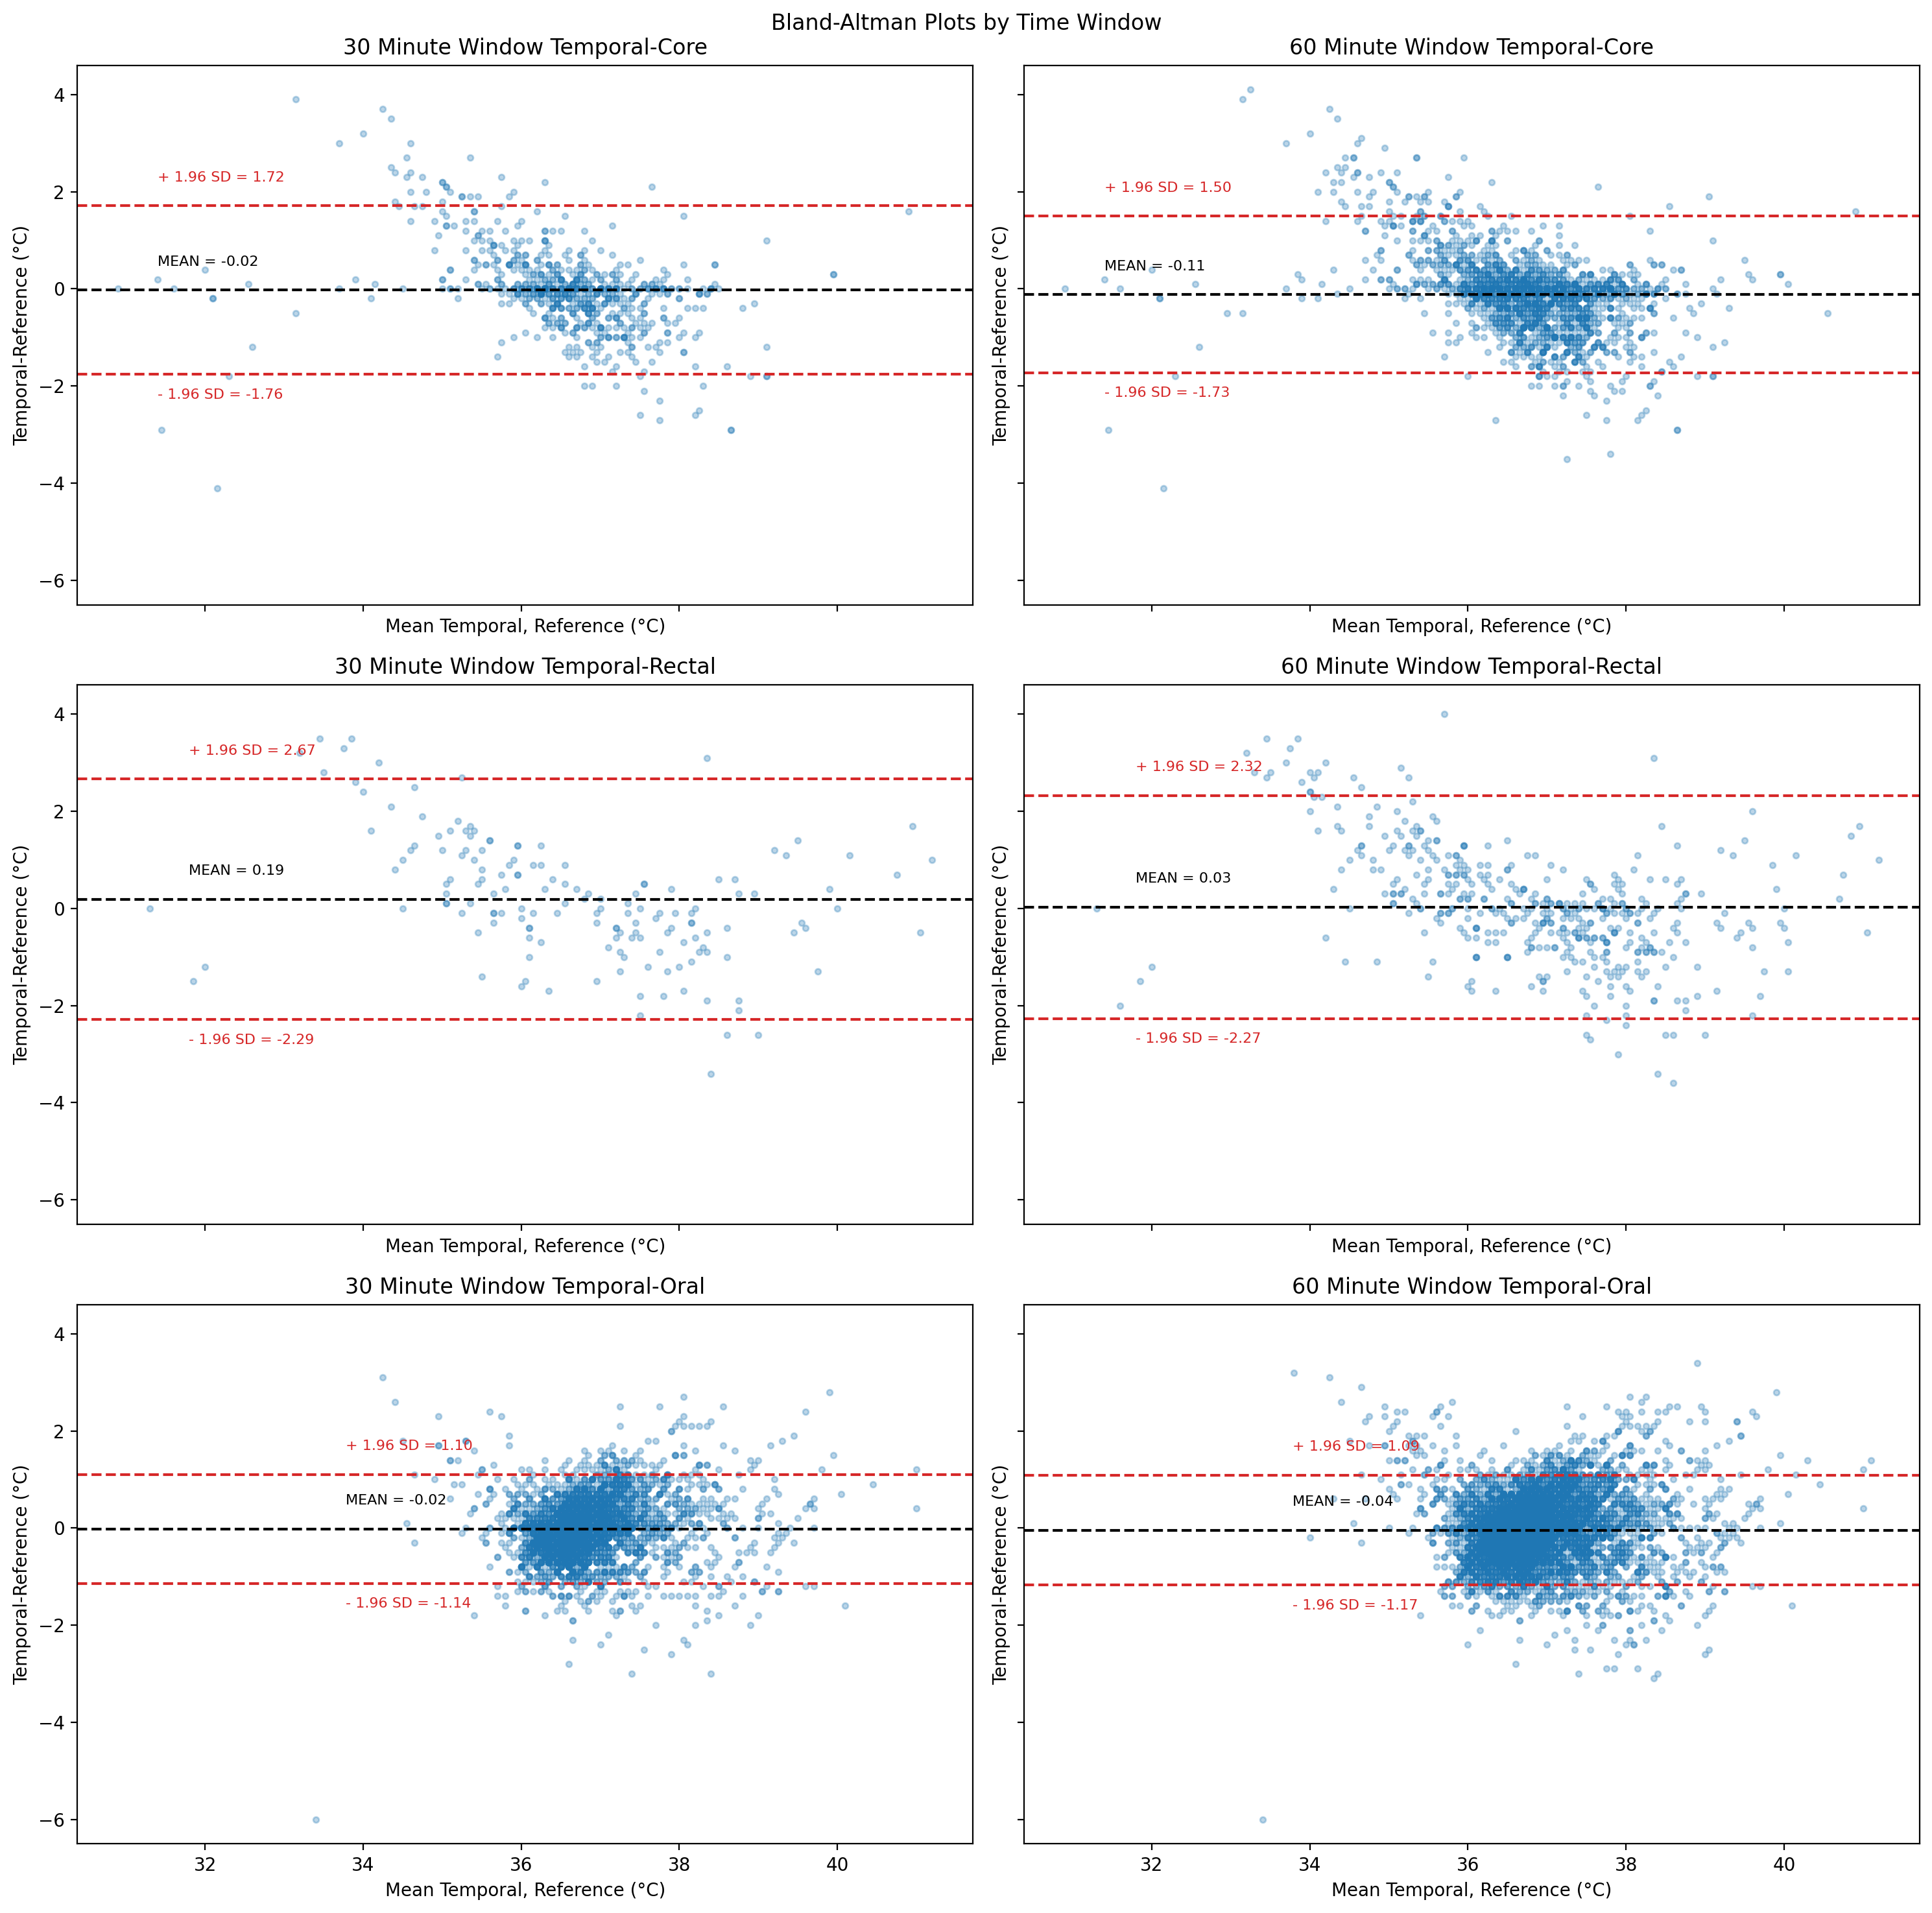

In [84]:
final_df_30_temporal_core = final_df_30[final_df_30["pair_type"] == 'temporal-core']
final_df_30_temporal_rectal = final_df_30[final_df_30["pair_type"] == 'temporal-rectal']
final_df_30_temporal_oral = final_df_30[final_df_30["pair_type"] == 'temporal-oral']


windows = [final_df_30_temporal_core, final_df_temporal_core, final_df_30_temporal_rectal, final_df_temporal_rectal, final_df_30_temporal_oral, final_df_temporal_oral]
titles = ['30 Minute Window Temporal-Core', '60 Minute Window Temporal-Core', '30 Minute Window Temporal-Rectal', '60 Minute Window Temporal-Rectal', '30 Minute Window Temporal-Oral', '60 Minute Window Temporal-Oral']


fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharex=True, sharey=True)

axs = axs.ravel()

for window, ax, title in zip(windows, axs, titles):
    plt.sca(ax)
    bland_altman_plot(window['temp_c_temporal'], window['temp_c_reference'])
    plt.title(f'{title}')

plt.suptitle('Bland-Altman Plots by Time Window')
plt.tight_layout()
plt.show()


### By DB

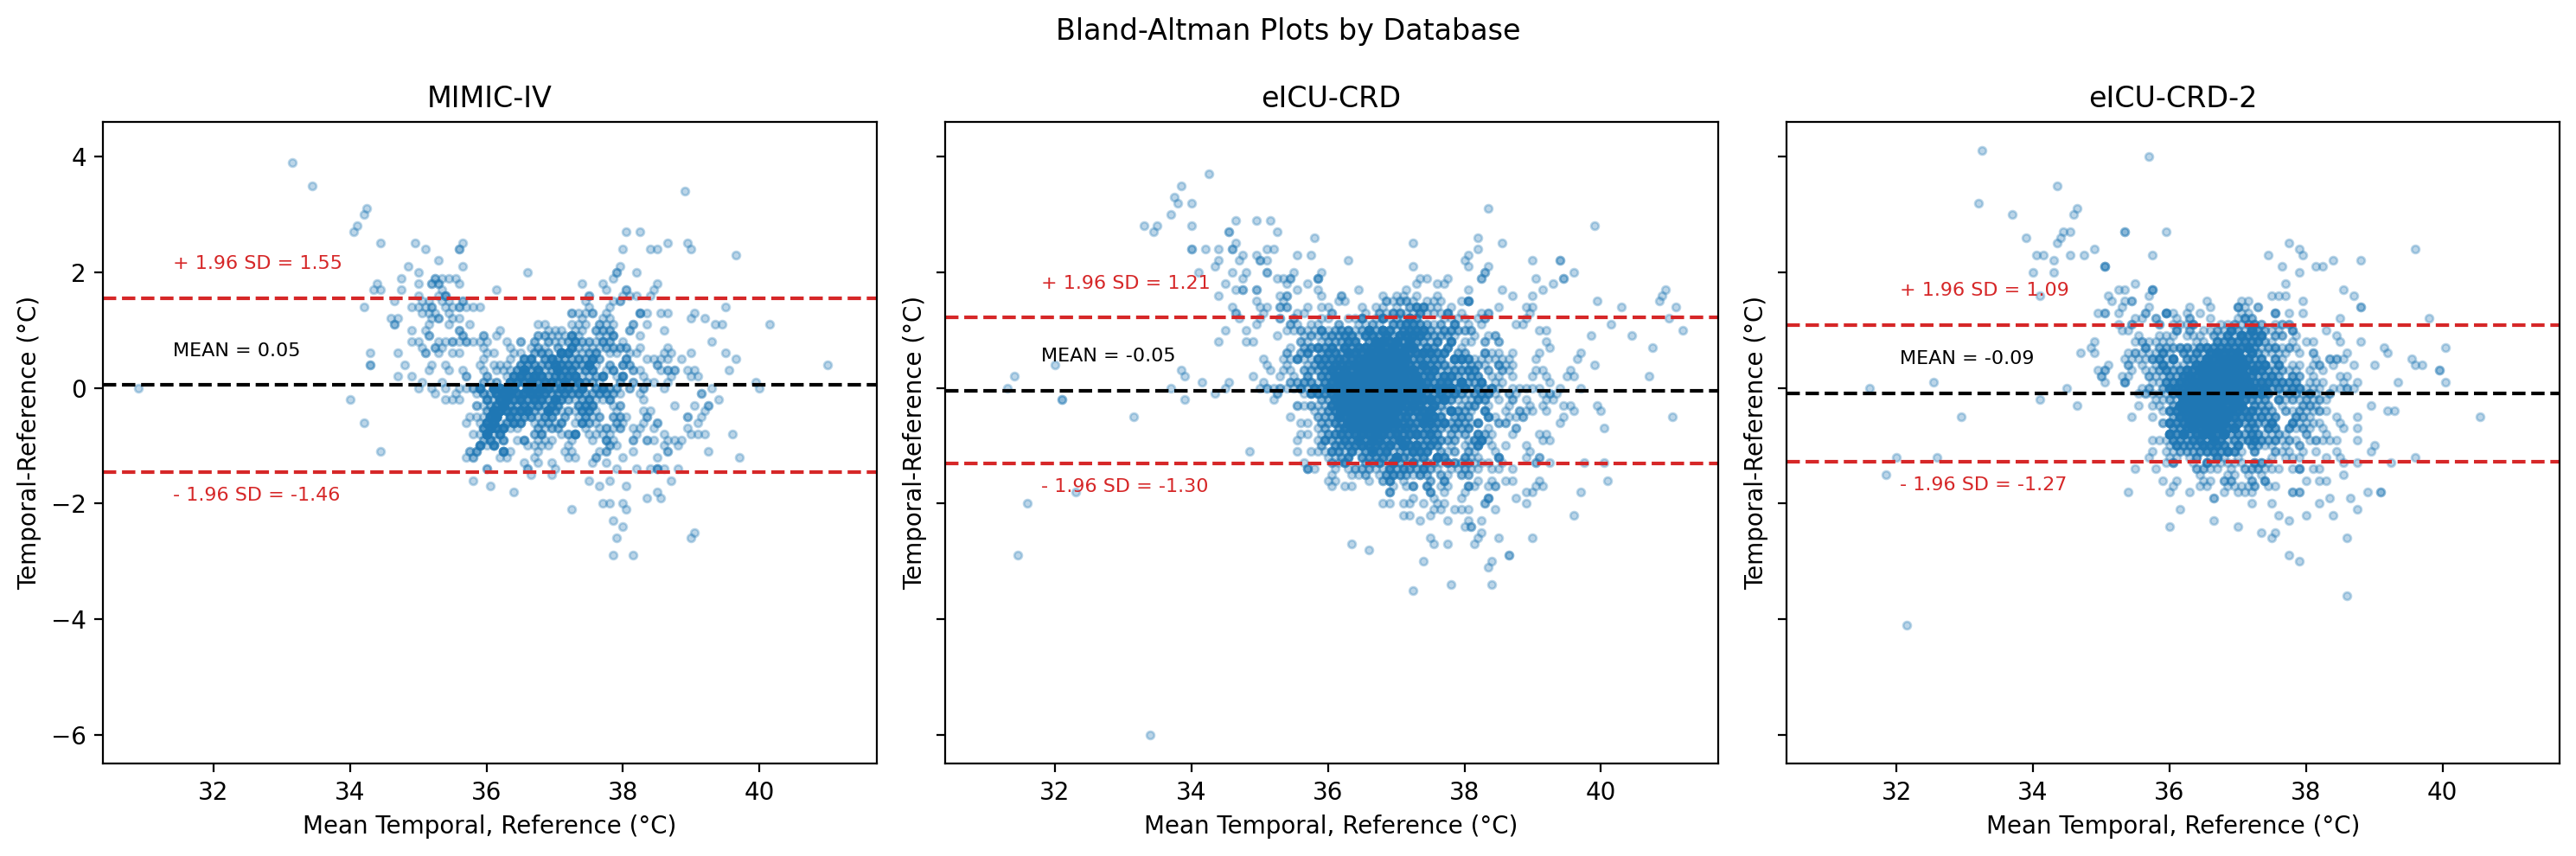

In [92]:
# split the dataset by db
final_df_mimic = final_df[final_df["source_db"] == 'mimic_iv']
final_df_eicu = final_df[final_df["source_db"] == 'eicu']
final_df_eicu2 = final_df[final_df["source_db"] == 'eicu2']

dbs = [final_df_mimic, final_df_eicu, final_df_eicu2]
titles = ['MIMIC-IV', 'eICU-CRD', 'eICU-CRD-2']


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for db, ax, title in zip(dbs, axs, titles):
    plt.sca(ax)
    bland_altman_plot(db['temp_c_temporal'], db['temp_c_reference'])
    plt.title(f'{title}')

plt.suptitle('Bland-Altman Plots by Database')
plt.tight_layout()
plt.show()


### By Race-Ethnicity

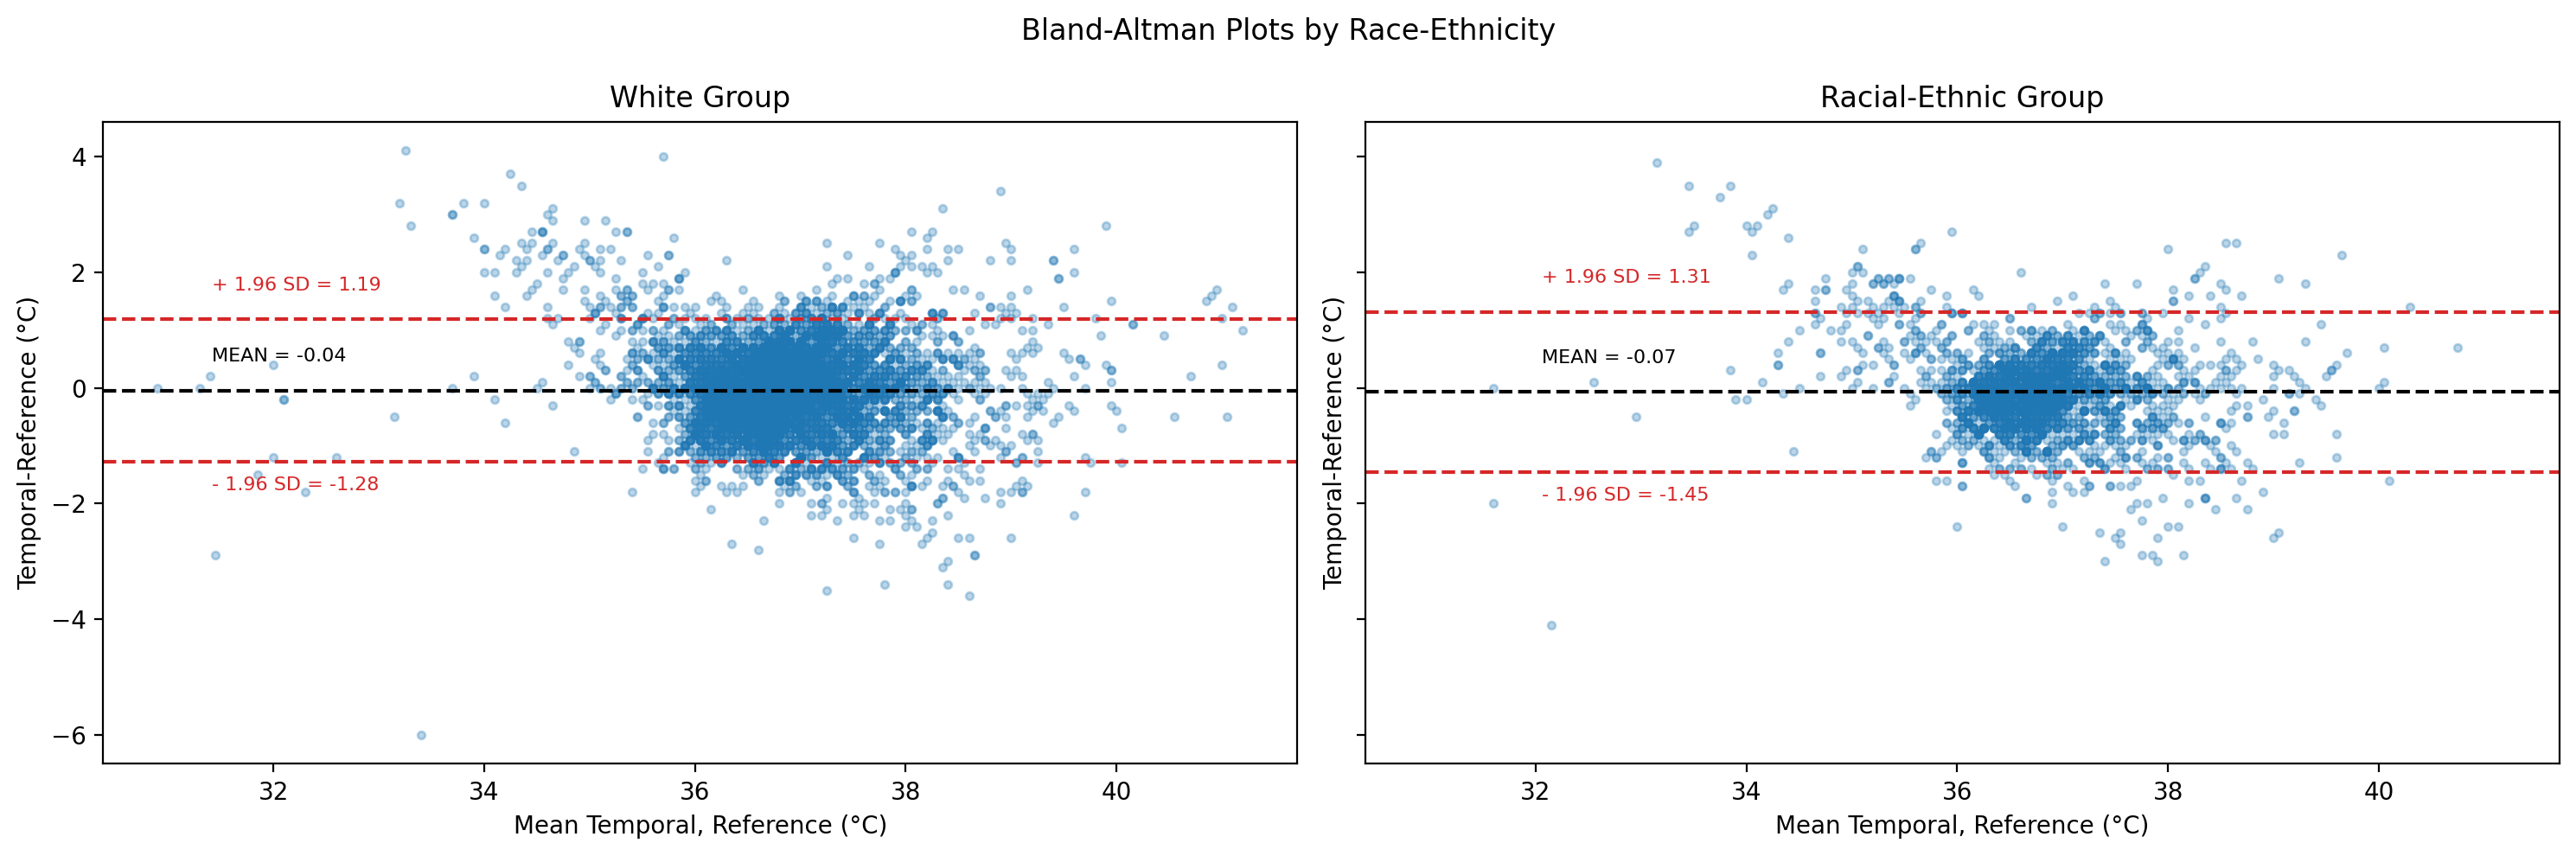

In [95]:
final_df['race_white'] = final_df['race_ethnicity'].apply(lambda x: 'White Group' if x == 'White' else 'Racial-Ethnic Group')
final_df_white = final_df[final_df['race_white'] == 'White Group']
final_df_reg = final_df[final_df['race_white'] == 'Racial-Ethnic Group']

comparisons = [final_df_white, final_df_reg]

titles = ['White Group', 'Racial-Ethnic Group']


fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for c, ax, title in zip(comparisons, axs, titles):
    plt.sca(ax)
    bland_altman_plot(c['temp_c_temporal'], c['temp_c_reference'])
    plt.title(f'{title}')

plt.suptitle('Bland-Altman Plots by Race-Ethnicity')
plt.tight_layout()
plt.show()


#### By Race-Ethnicy + Time Window

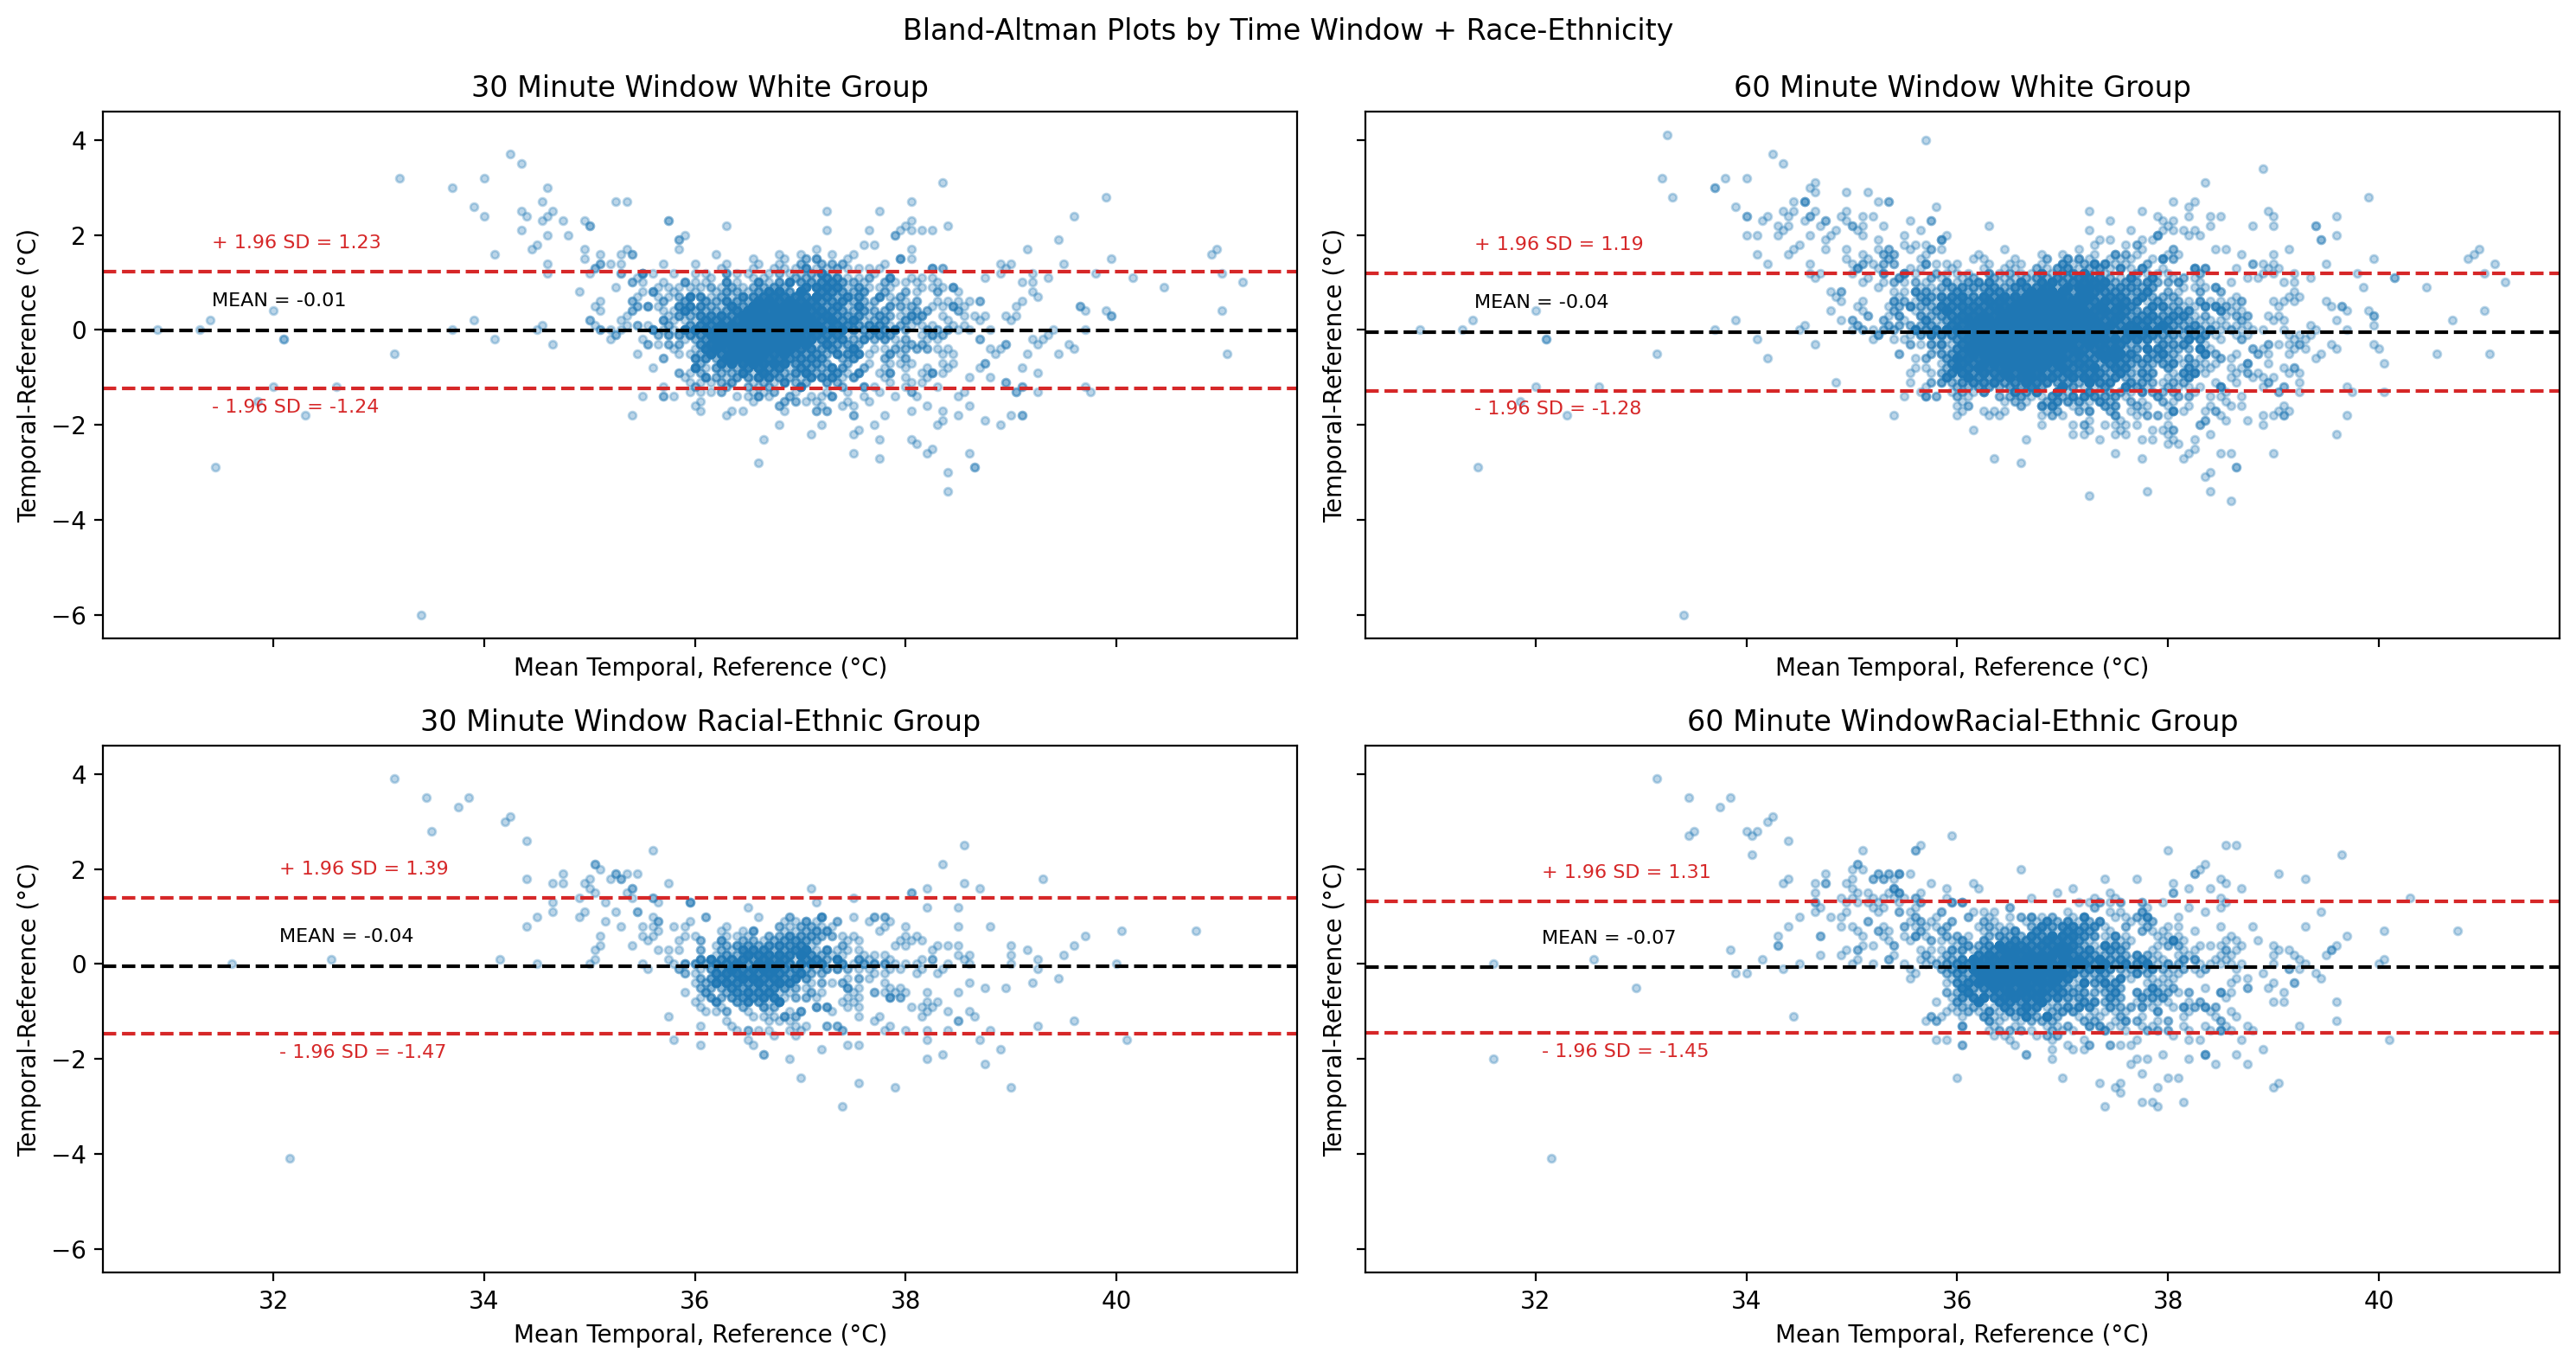

In [98]:
final_df_white_30 = final_df_white[final_df_white['difference_in_minutes'] <= 30]
final_df_reg_30 = final_df_reg[final_df_reg['difference_in_minutes'] <= 30]


windows = [final_df_white_30, final_df_white, final_df_reg_30, final_df_reg]
titles = ['30 Minute Window White Group', '60 Minute Window White Group', '30 Minute Window Racial-Ethnic Group', '60 Minute WindowRacial-Ethnic Group']


fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.ravel()

for window, ax, title in zip(windows, axs, titles):
    plt.sca(ax)
    bland_altman_plot(window['temp_c_temporal'], window['temp_c_reference'])
    plt.title(f'{title}')

plt.suptitle('Bland-Altman Plots by Time Window + Race-Ethnicity')
plt.tight_layout()
plt.show()

## Sample size by Time Difference

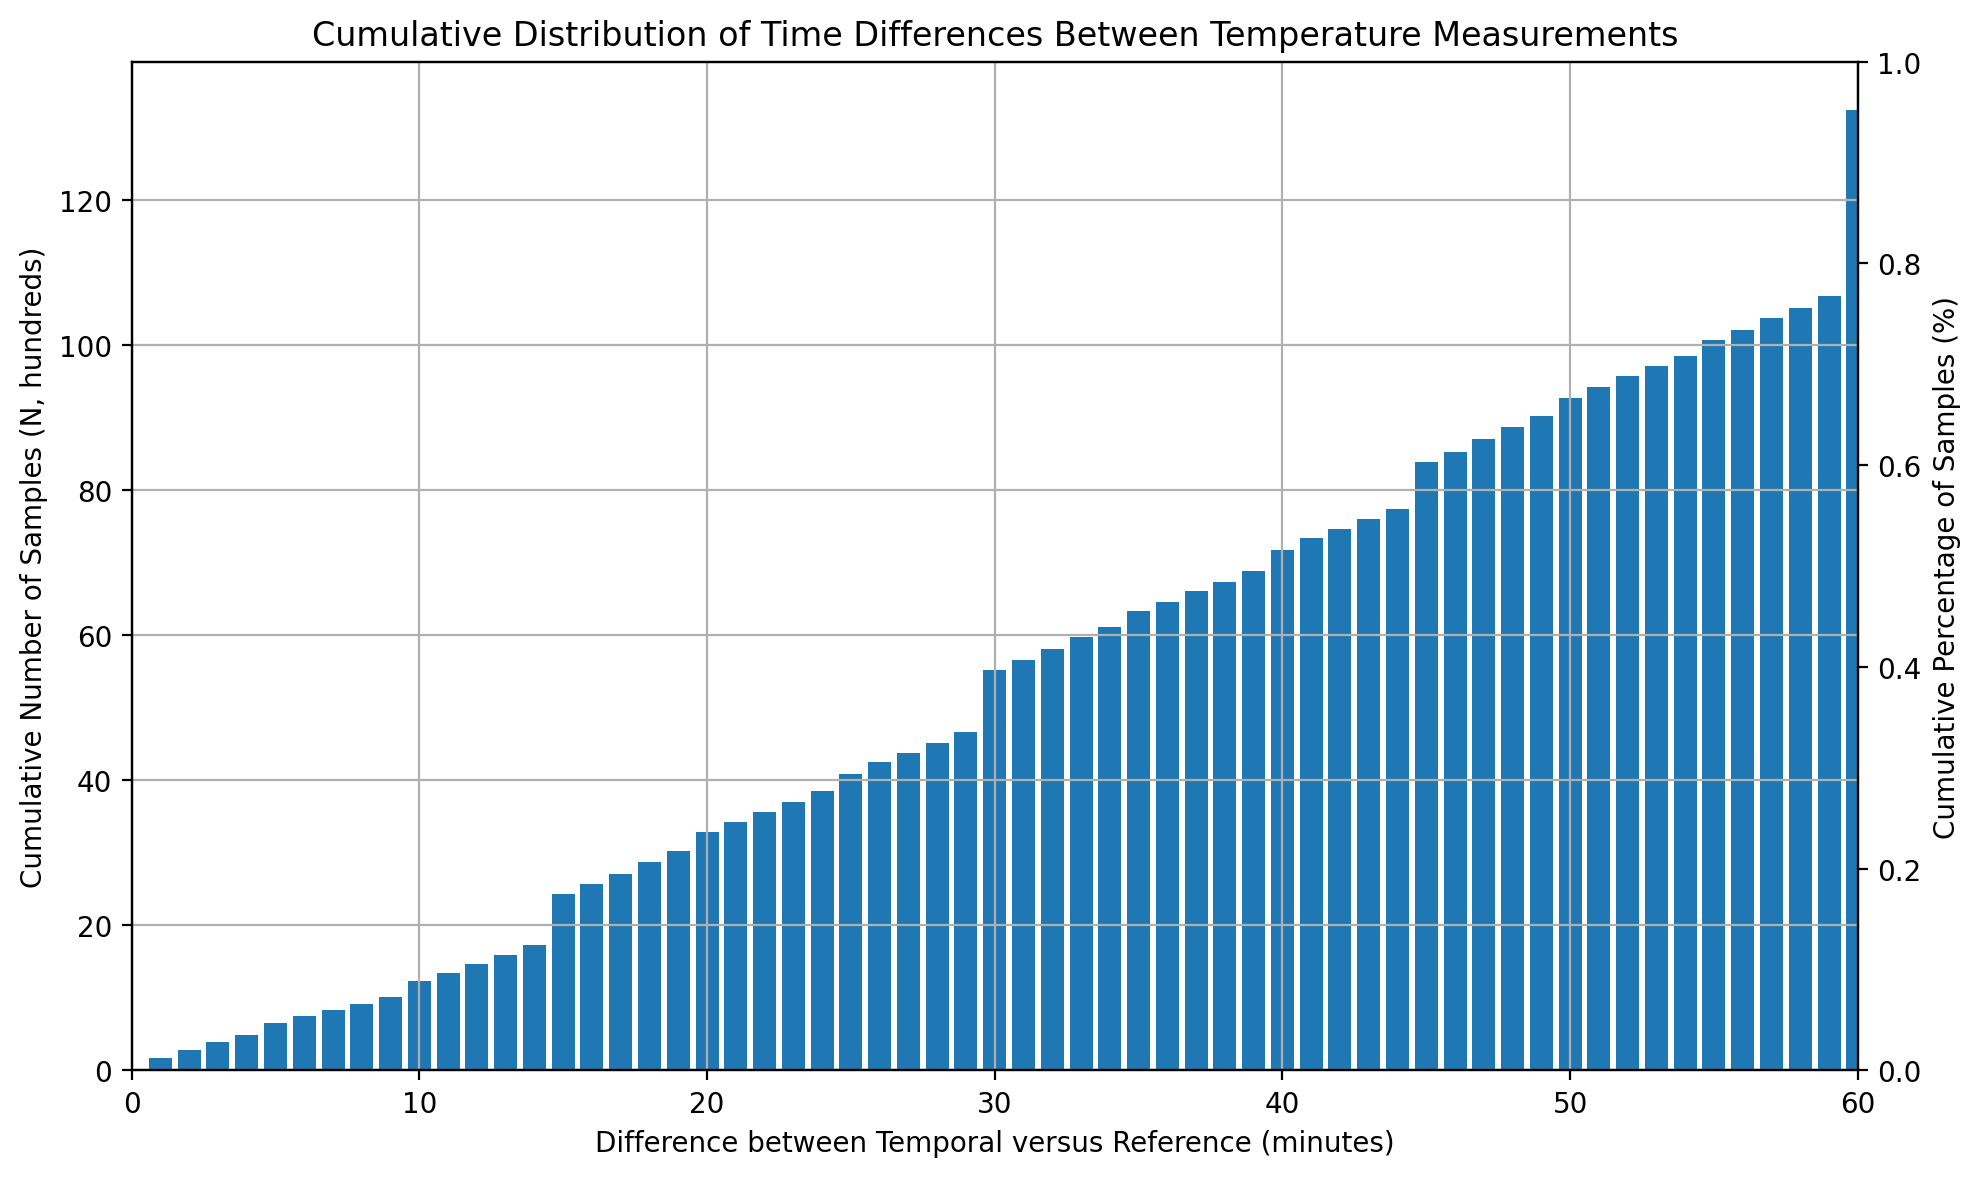

In [124]:
count_df = final_df.groupby('difference_in_minutes').size().reset_index(name='counts')
# hundreds due to less sample size
count_df = count_df.sort_values(by='difference_in_minutes', ascending=True)

count_df['cumulative_counts'] = count_df['counts'].cumsum() / 100

count_df['cumulative_percentage'] = 100 * count_df['cumulative_counts'] / count_df['cumulative_counts'].sum()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(count_df['difference_in_minutes'], count_df['cumulative_counts'])
ax1.set_xlabel('Difference between Temporal versus Reference (minutes)')
ax1.set_ylabel('Cumulative Number of Samples (N, hundreds)')
ax1.set_xlim([0, 60])
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Percentage of Samples (%)')

plt.title('Cumulative Distribution of Time Differences Between Temperature Measurements')
plt.tight_layout()
plt.show()

## Temp difference by Race-Ethnciity
- I use absolute value but not sure if that is the correct approach
- Graphs show a large CI band in the first 5 minutes (temporal and reference temperatures are taken 5 minutes apart) but it condensense after
- Does this negate what I see in the band altman plots?

In [150]:
final_df["temp_diff"] = abs(final_df["temp_c_temporal"] - final_df["temp_c_reference"])

from sklearn.utils import resample

# use bootstrap to not assume normal distriution
def bootstrap_ci(data, num_bootstrap=1000, ci=95):
    boot_means = []

    # Perform bootstrapping
    for _ in range(num_bootstrap):
        sample = resample(data)
        boot_means.append(np.mean(sample))

    # Calculate the percentiles for the CI
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    ci_lower = np.percentile(boot_means, lower_percentile)
    ci_upper = np.percentile(boot_means, upper_percentile)

    return np.mean(data), ci_lower, ci_upper

def temp_diff_with_ci(subset_df):
    temp_diff = subset_df['temp_diff'].values
    return bootstrap_ci(temp_diff)


def plot_temp_diff_subplots(df, race_ethnicity_values):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, race in enumerate(race_ethnicity_values):
        subset_df = df[df['race_ethnicity'] == race]
        temp_diff_df = pd.DataFrame(columns=['difference_in_minutes', 'temp_diff_mean', 'ci_lower', 'ci_upper'])

        # Loop through unique time differences in ascending order
        for value in sorted(subset_df['difference_in_minutes'].unique()):
            subset = subset_df[subset_df['difference_in_minutes'] <= value]
            temp_diff_mean, ci_lower, ci_upper = temp_diff_with_ci(subset)
            temp_diff_df.loc[len(temp_diff_df)] = [value, temp_diff_mean, ci_lower, ci_upper]
            # print(race)
            # print([value, temp_diff_mean, ci_lower, ci_upper])

        ax = axes[i]

        # Plotting the temperature difference mean
        ax.plot(temp_diff_df['difference_in_minutes'], temp_diff_df['temp_diff_mean'], color='black', label='Temperature Difference')

        # Shading the area between the confidence intervals
        ax.fill_between(temp_diff_df['difference_in_minutes'], temp_diff_df['ci_lower'], temp_diff_df['ci_upper'],
                        color='gray', alpha=0.1, label='95% CI')

        ax.set_ylabel('Temperature Difference (°C)')
        ax.set_xlabel('Time Difference (Minutes)')
        ax.grid(True)

        # Set title depending on the race_ethnicity
        title = f"{race}"
        ax.set_title(title)

    # Add a legend to the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
    plt.suptitle("Temperature Difference Over Time by Race/Ethnicity")
    plt.tight_layout()
    plt.show()

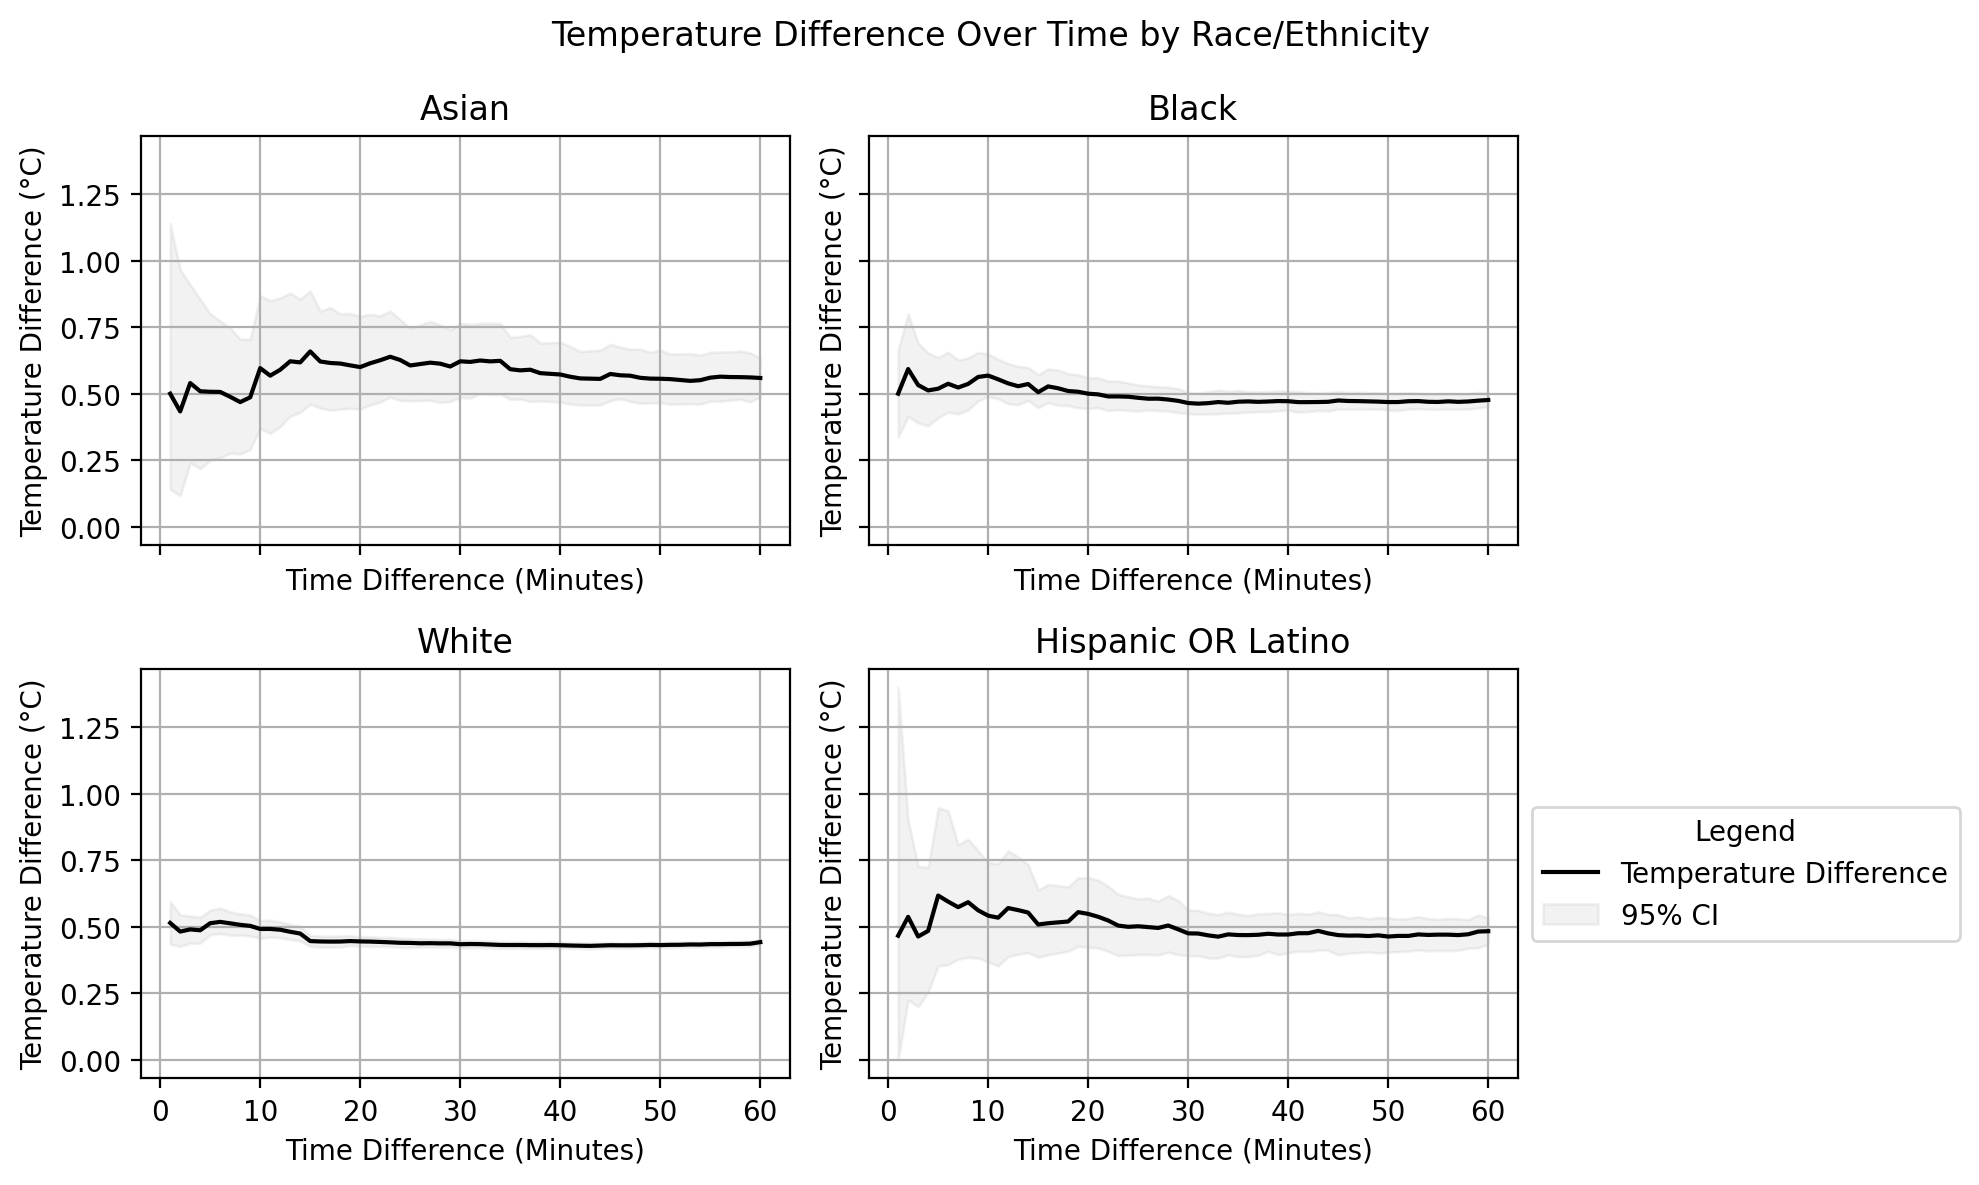

In [151]:
race_ethnicity_values = ['Asian', 'Black', 'White', 'Hispanic OR Latino']

plot_temp_diff_subplots(final_df, race_ethnicity_values)

In [154]:
check = final_df[final_df['difference_in_minutes'] <= 1]
check = check[check["race_ethnicity"] == "Asian"]
check

unique_subject_id  unique_hospital_admission_id  unique_icustay_id  \
3186               7203                          7332               7402   
3673               6514                          6640               6700   
4079               7320                          7451               7524   
7352               7305                          7436               7509   
7441               7320                          7451               7524   

      icustay_id  hospital_admission_id        subject_id  pair_id   pair_seq  \
3186     6919921                5617667  032-125220-478.0    10782  6919921-1   
3673     7156533                5828899   028-8072-1716.0    10987  7156533-1   
4079     7029011                5715397    032-178192-nan     9036  7029011-3   
7352     7002416                5691581  032-171845-286.0     7937  7002416-1   
7441     7029011                5715397    032-178192-nan    11560  7029011-2   

      total_no_pairs source_db  ... race_ethnicity  comorbidity_score_name  \
3186               3     eicu2  ...          Asian                Charlson   
3673               1     eicu2  ...          Asian                Charlson   
4079               3     eicu2  ...          Asian                Charlson   
7352               1     eicu2  ...          Asian                Charlson   
7441               3     eicu2  ...          Asian                Charlson   

     comorbidity_score_value  sofa_day1 hidden_fever hidden_hypothermia  \
3186                       2        4.0        False              False   
3673                       2       10.0        False              False   
4079                       1        1.0        False              False   
7352                       2        6.0        False              False   
7441                       1        1.0        False              False   

      hidden_SIRS  difference_in_minutes           race_white  temp_diff  
3186        False                    1.0  Racial-Ethnic Group        1.7  
3673        False                    1.0  Racial-Ethnic Group        0.0  
4079        False                    1.0  Racial-Ethnic Group        0.2  
7352        False                    1.0  Racial-Ethnic Group        0.3  
7441        False                    1.0  Racial-Ethnic Group        0.3  

[5 rows x 180 columns]

In [156]:
def plot_temp_diff_and_counts(df, race_ethnicity_values):
    # Loop through each race/ethnicity group and create a separate plot
    for race_ethnicity in race_ethnicity_values:
        # Filter the dataframe by the current race/ethnicity
        subset_df = df[df['race_ethnicity'] == race_ethnicity]

        if len(subset_df) == 0:
            print(f"No data for {race_ethnicity}")
            continue

        # Group by time difference to count occurrences
        count_df = subset_df.groupby('difference_in_minutes').size().reset_index(name='counts')
        count_df = count_df.sort_values(by= 'difference_in_minutes', ascending=True)

        # Calculate cumulative counts
        count_df['cumulative_counts'] = count_df['counts'].cumsum()

        # Prepare for temperature difference calculation with CI
        temp_diff_df = pd.DataFrame(columns=['difference_in_minutes', 'temp_diff_mean', 'ci_lower', 'ci_upper'])

        # Loop through unique time differences and calculate the mean and CI
        for value in sorted(subset_df['difference_in_minutes'].unique()):
            temp_diff_mean, ci_lower, ci_upper = temp_diff_with_ci(subset_df[subset_df['difference_in_minutes'] <= value])
            temp_diff_df.loc[len(temp_diff_df)] = [value, temp_diff_mean, ci_lower, ci_upper]

        # Create the twin plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # First plot: cumulative counts as a bar chart
        ax1.bar(count_df['difference_in_minutes'], count_df['cumulative_counts'], color='lightblue', label='Cumulative Counts')
        ax1.set_xlabel('Difference between Temporal vs. Reference (minutes)')
        ax1.set_ylabel('Cumulative Number of Samples (N)')
        ax1.set_xlim([0, max(subset_df['difference_in_minutes'])])
        ax1.grid(True)

        # Create twin axis for temperature difference
        ax2 = ax1.twinx()
        ax2.plot(temp_diff_df['difference_in_minutes'], temp_diff_df['temp_diff_mean'], color='black', label='Temperature Difference')

        # Shading the confidence intervals for temperature difference
        ax2.fill_between(temp_diff_df['difference_in_minutes'], temp_diff_df['ci_lower'], temp_diff_df['ci_upper'],
                         color='gray', alpha=0.2, label='95% CI')

        ax2.set_ylabel('Temperature Difference (°C)')

        # Add legend
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # Title for each ethnicity
        plt.title(f'Temperature Difference and Cumulative Counts over Time Differences for {race_ethnicity}')
        plt.tight_layout()
        plt.show()

### Sample size by Time Difference per Race-Ethnicity

In [129]:
from scipy import stats

def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean, se = np.mean(data), stats.sem(data)
    std = np.std(data)
    h = se * 1.96  # Using 1.96 as the z-value for a 95% CI with a normal distribution
    return abs(round(mean, 3)), std, abs(round(mean - h, 3)), abs(round(mean + h, 3)), n

def get_deltas(df):

  counts = df.groupby('race_ethnicity')['difference_in_minutes'].count().reset_index()
  # display(counts)
  counts.rename(columns={'difference_in_minutes': 'N'}, inplace=True)
  results = df.groupby('race_ethnicity')['difference_in_minutes'].apply(mean_confidence_interval).reset_index()
  # display(results)
  results = pd.merge(results, counts, on='race_ethnicity')
  results[['mean','std', '2.5%', '97.5%', 'N']] = pd.DataFrame(results['difference_in_minutes'].tolist(), index=results.index)
  results.drop(columns=['difference_in_minutes'], inplace=True)

  # keep eveything except "More Than One Race"
  results = results[(results.race_ethnicity != "More Than One Race")].reset_index()

  return results

results_clean = get_deltas(final_df)

results_clean

race_ethnicity  difference_in_minutes
0     American Indian / Alaska Native                    108
1                               Asian                    271
2                               Black                   1302
3                  Hispanic OR Latino                    358
4  Native Hawaiian / Pacific Islander                     15
5                             Unknown                    840
6                               White                  10357

race_ethnicity  \
0     American Indian / Alaska Native   
1                               Asian   
2                               Black   
3                  Hispanic OR Latino   
4  Native Hawaiian / Pacific Islander   
5                             Unknown   
6                               White   

                               difference_in_minutes  
0   (35.694, 17.46184111317384, 32.386, 39.003, 108)  
1    (37.48, 18.64047478692157, 35.256, 39.703, 271)  
2  (36.392, 18.422841763116743, 35.391, 37.393, 1...  
3  (39.782, 18.593640829384544, 37.853, 41.711, 358)  
4    (52.667, 18.696404883173543, 42.873, 62.46, 15)  
5   (40.212, 18.790520689977026, 38.94, 41.483, 840)  
6  (36.295, 18.171620841564717, 35.945, 36.645, 1...

index                      race_ethnicity      N    mean        std  \
0      0     American Indian / Alaska Native    108  35.694  17.461841   
1      1                               Asian    271  37.480  18.640475   
2      2                               Black   1302  36.392  18.422842   
3      3                  Hispanic OR Latino    358  39.782  18.593641   
4      4  Native Hawaiian / Pacific Islander     15  52.667  18.696405   
5      5                             Unknown    840  40.212  18.790521   
6      6                               White  10357  36.295  18.171621   

     2.5%   97.5%  
0  32.386  39.003  
1  35.256  39.703  
2  35.391  37.393  
3  37.853  41.711  
4  42.873  62.460  
5  38.940  41.483  
6  35.945  36.645

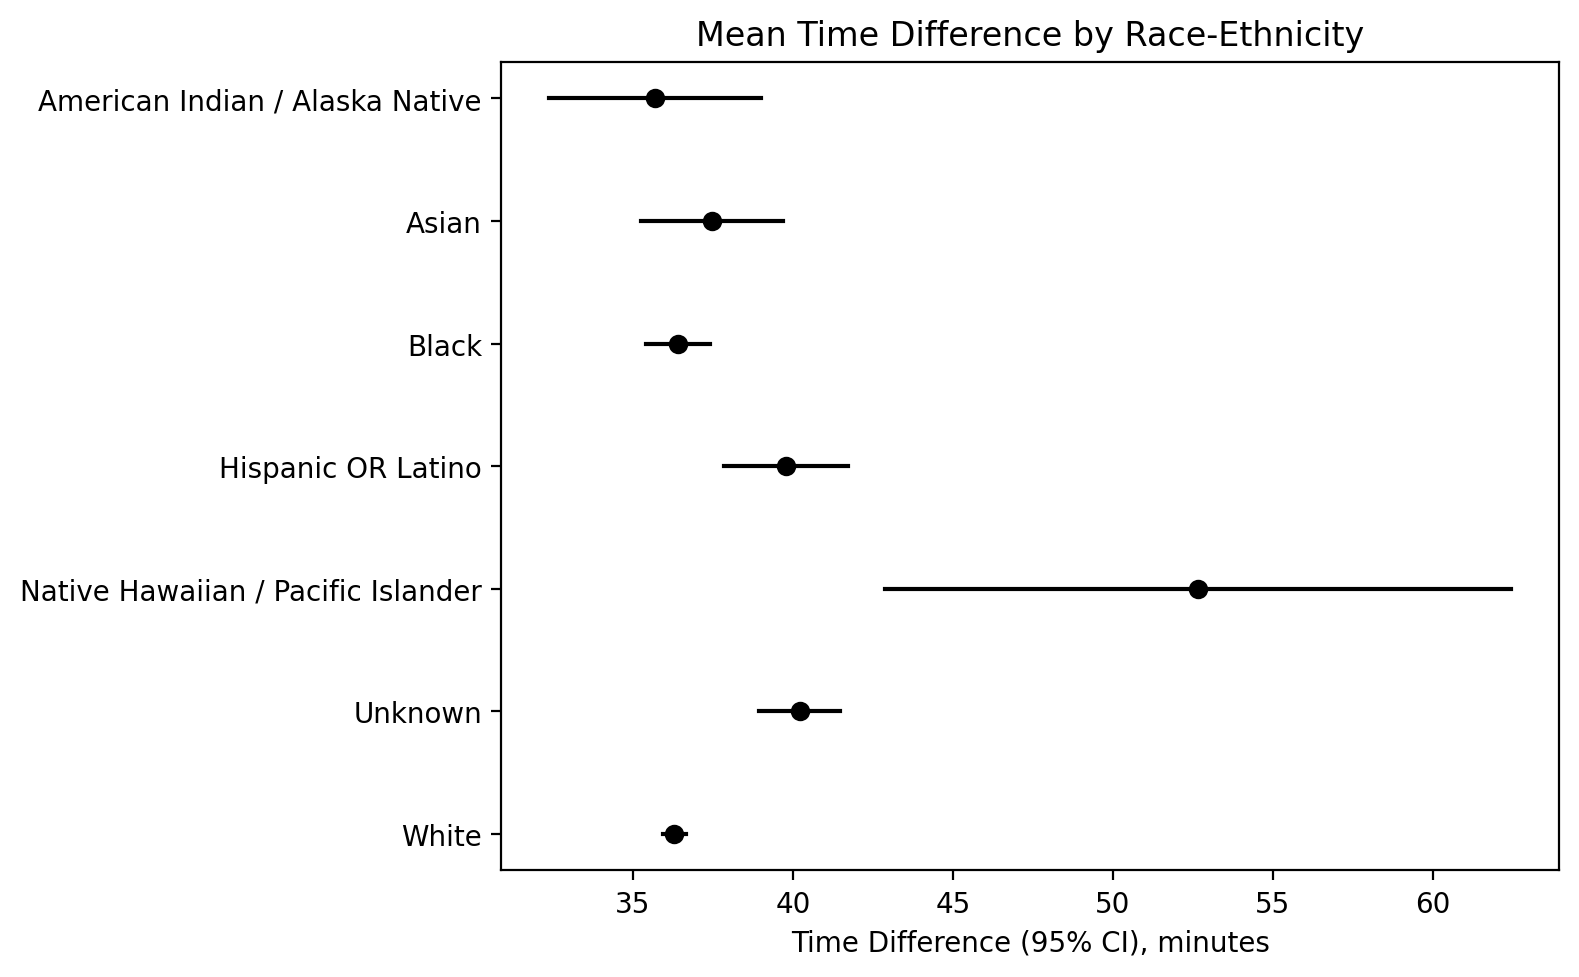

In [131]:
def plot_deltas(results):

  plt.figure(figsize=(8, len(results)-2))

  # Plotting the means and confidence intervals for each group
  for idx, row in results.iterrows():
      plt.plot([row['2.5%'], row['97.5%']], [idx, idx], color='black')
      plt.plot(row['mean'], idx, 'o', color='black')

  plt.yticks(range(len(results)), results['race_ethnicity']) # Setting the y-tick labels
  plt.xlabel('Time Difference (95% CI), minutes')
  plt.title('Mean Time Difference by Race-Ethnicity')
  plt.gca().invert_yaxis() # To display the first entry at the top
  plt.tight_layout()
  plt.show()

plot_deltas(results_clean)

In [134]:
# Count pairs per hadm_id
pairs_per_hadm_id = final_df.groupby('hospital_admission_id').size().reset_index(name='pairs')

# Merge with race/ethnicity information
pairs_with_race = pd.merge(pairs_per_hadm_id, final_df[['hospital_admission_id', 'race_ethnicity']]\
                           .drop_duplicates(), on='hospital_admission_id')

# Function to compute mean, confidence intervals, and number of pairs
def compute_stats(data):
    mean, std, ci_lower, ci_upper, n = mean_confidence_interval(data['pairs'])
    return pd.Series({'mean': mean, 'std': std, '2.5%': ci_lower, '97.5%': ci_upper, 'N': n})

# Group by race_ethnicity and apply the compute_stats function
results = pairs_with_race.groupby('race_ethnicity').apply(compute_stats).reset_index()

# Optional: Filter results (e.g., remove groups with fewer than 50 pairs)
results = results.loc[results.N >= 50].reset_index()


In [137]:
results_docs = results[['race_ethnicity', 'mean', 'std', 'N']].round(2)

# Convert the subset dataframe to string format
table_string = results_docs.to_string(index=False)

print(table_string)

                 race_ethnicity  mean  std      N
American Indian / Alaska Native  1.93 2.24   56.0
                          Asian  1.81 1.40  150.0
                          Black  1.57 1.34  827.0
             Hispanic OR Latino  1.49 1.18  240.0
                        Unknown  1.42 0.90  590.0
                          White  1.52 1.16 6794.0


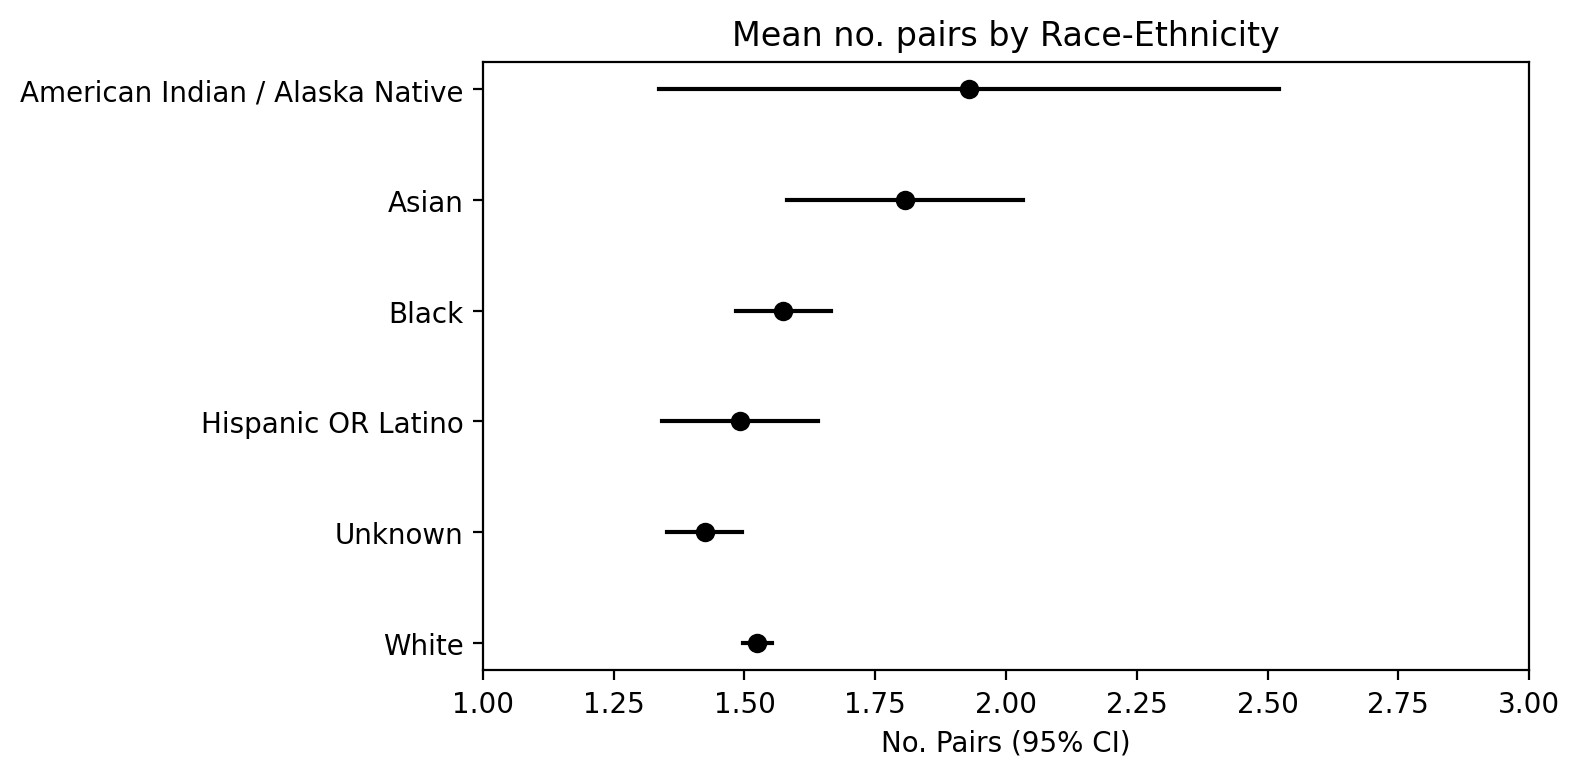

In [139]:
plt.figure(figsize=(8, len(results)-2))

# Plotting the means and confidence intervals for each group
for idx, row in results.iterrows():
    plt.plot([row['2.5%'], row['97.5%']], [idx, idx], color='black')
    plt.plot(row['mean'], idx, 'o', color='black')

plt.yticks(range(len(results)), results['race_ethnicity']) # Setting the y-tick labels
plt.xlim([1,3])
plt.xlabel('No. Pairs (95% CI)')
plt.title('Mean no. pairs by Race-Ethnicity')
plt.gca().invert_yaxis() # To display the first entry at the top
plt.tight_layout()
plt.show()